**DATA SCIENCE LAB PROJECT**

*Nicole Gemelli 880002, Federica Romano 931429, Davide Tortorella 926136, Francesca Verna 880290*

## Research Question

The aim of this project is to quantify and analyze the East–West divide in Europe through a multi-dimensional clustering approach, combining socio-economic indicators with measures of political freedom.  

Specifically, this study seeks to answer the following research question:

**"To what extent does a gap exist between Eastern and Western regions of Europe? A clustering analysis based on socio-economic and political indicators."**


In [1]:
import pandas as pd
import numpy as np, random, os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.inspection import permutation_importance
from numpy.linalg import norm
import plotly.io as pio
import plotly.express as px

In [2]:
np.random.seed(42); random.seed(42)

## **IMPORT**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = "/content/drive/MyDrive/DSLAB/OECD-Regional-Well-Being-Data-File.xlsx"
sheet_name = "Indicator_Last"


df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=6)


if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])


df = df[~df["Country"].isna()].copy()


df.columns = [c.strip() if isinstance(c, str) else c for c in df.columns]


OECD_WEST = {
    "Austria","Belgium","Denmark","Finland","France","Germany","Greece",
    "Iceland","Ireland","Italy","Luxembourg","Netherlands","Norway",
    "Portugal","Spain","Sweden","Switzerland","United Kingdom"
}
OECD_EAST = {
    "Czech Republic","Estonia","Hungary","Latvia","Lithuania",
    "Poland","Slovak Republic","Slovenia"
}
OECD_EUROPE = OECD_WEST | OECD_EAST

df = df[df["Country"].isin(OECD_EUROPE)].copy()


var_map = {
    "Country": "country",
    "Region": "region",
    "Code": "code",
    "Household disposable income per capita": "disp_income_pc",
    "Employment rate": "employment_rate",
    #"Unemploy-ment rate": "unemployment_rate",
    "Life expectancy": "life_expectancy",
    "Population with at least secondary education": "secondary_edu_pct",
    'Homicide rate': 'homicide_rate',
    'Mortality rate': 'mortality_rate',
    'Air pollution (level of PM2.5)': 'air_pollution',
    'Voter turnout': 'voter_turnout',
    'Broadband access': 'broadband_access',
    'Internet download speed 2021-Q4' : 'internet_speed',
    'Number of rooms per person': 'number_rooms',
    'Perceived social network support': 'social_support',
    'Self assessment of life satisfaction': 'life_satisfaction'

}


keep_cols = [c for c in var_map if c in df.columns]
df = df[keep_cols].rename(columns=var_map)


for col in df.columns:
    if col not in ["country","region","code"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")


def to_macro(country):
    if country in OECD_EAST:
        return "East"
    elif country in OECD_WEST:
        return "West"
    else:
        return np.nan

df["macro_area"] = df["country"].apply(to_macro)


print("Final Shape:", df.shape)
print("Countries:", sorted(df["country"].unique()))
df.head()


Final Shape: (225, 17)
Countries: ['Austria', 'Belgium', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom']


country         region  code  disp_income_pc  employment_rate  \
9   Austria     Burgenland  AT11           26701             71.8   
10  Austria  Lower Austria  AT12           26967             73.9   
11  Austria         Vienna  AT13           24015             66.2   
12  Austria      Carinthia  AT21           25178             70.7   
13  Austria         Styria  AT22           25614             72.9   

    life_expectancy  secondary_edu_pct  homicide_rate  mortality_rate  \
9              81.8               87.0            1.0            7.71   
10             81.3               87.2            0.5            7.89   
11             80.2               83.4            0.6            7.87   
12             81.4               89.6            0.4            7.32   
13             81.1               86.9            0.4            7.28   

    air_pollution  voter_turnout  broadband_access  internet_speed  \
9            11.3           81.5              91.0      -46.385558   
10           11.1           80.6              91.0      -47.887224   
11           12.4           72.0              93.0      -11.428069   
12           10.2           72.4              90.0      -54.651967   
13           12.0           74.8              90.0      -53.768888   

    number_rooms  social_support  life_satisfaction macro_area  
9           1.94            87.3                6.6       West  
10          1.90            92.6                7.3       West  
11          1.62            89.0                7.1       West  
12          1.95            91.9                7.4       West  
13          1.89            87.7                7.2       West

In [5]:
fh_path = "/content/drive/MyDrive/DSLAB/All_data_FIW_2013-2024.xlsx"


fh_df = pd.read_excel(fh_path, sheet_name="FIW13-25", header=1)


fh_df = fh_df[fh_df["Edition"] == 2021].copy()


cols_keep = ["Country/Territory", "Edition", "Total", "PR rating", "CL rating"]
fh_df = fh_df[cols_keep].rename(columns={
    "Country/Territory": "country_fh",
    "Total": "freedom_score",
    "PR rating": "political_rights",
    "CL rating": "civil_liberties"
})

#for better analysis, we invert the values of political_rights and civil_liberties so higher values correspond to better outcomes
fh_df["political_rights"] = fh_df["political_rights"].max() +1 - fh_df["political_rights"]
fh_df["civil_liberties"] = fh_df["civil_liberties"].max() +1 - fh_df["civil_liberties"]


name_map = {
    "Czechia": "Czech Republic",
    "Slovakia": "Slovak Republic",
    "United Kingdom (UK)": "United Kingdom"
}
fh_df["country_fh"] = fh_df["country_fh"].replace(name_map)


df_merged = df.merge(
    fh_df[["country_fh", "freedom_score", "political_rights", "civil_liberties"]],
    left_on="country",
    right_on="country_fh",
    how="left"
)


df_merged = df_merged.drop(columns=["country_fh"])


print("Final Shape:", df_merged.shape)
print("\nMissing Values post-merge:\n", df_merged.isna().sum())
df_merged.head()

Final Shape: (225, 20)

Missing Values post-merge:
 country              0
region               0
code                 0
disp_income_pc       0
employment_rate      1
life_expectancy      2
secondary_edu_pct    3
homicide_rate        0
mortality_rate       0
air_pollution        0
voter_turnout        0
broadband_access     2
internet_speed       0
number_rooms         3
social_support       5
life_satisfaction    5
macro_area           0
freedom_score        0
political_rights     0
civil_liberties      0
dtype: int64


country         region  code  disp_income_pc  employment_rate  \
0  Austria     Burgenland  AT11           26701             71.8   
1  Austria  Lower Austria  AT12           26967             73.9   
2  Austria         Vienna  AT13           24015             66.2   
3  Austria      Carinthia  AT21           25178             70.7   
4  Austria         Styria  AT22           25614             72.9   

   life_expectancy  secondary_edu_pct  homicide_rate  mortality_rate  \
0             81.8               87.0            1.0            7.71   
1             81.3               87.2            0.5            7.89   
2             80.2               83.4            0.6            7.87   
3             81.4               89.6            0.4            7.32   
4             81.1               86.9            0.4            7.28   

   air_pollution  voter_turnout  broadband_access  internet_speed  \
0           11.3           81.5              91.0      -46.385558   
1           11.1           80.6              91.0      -47.887224   
2           12.4           72.0              93.0      -11.428069   
3           10.2           72.4              90.0      -54.651967   
4           12.0           74.8              90.0      -53.768888   

   number_rooms  social_support  life_satisfaction macro_area  freedom_score  \
0          1.94            87.3                6.6       West             93   
1          1.90            92.6                7.3       West             93   
2          1.62            89.0                7.1       West             93   
3          1.95            91.9                7.4       West             93   
4          1.89            87.7                7.2       West             93   

   political_rights  civil_liberties  
0                 7                7  
1                 7                7  
2                 7                7  
3                 7                7  
4                 7                7

## **EDA**

In [6]:
missing_summary = df_merged.isna().sum().sort_values(ascending=False)
missing_pct = (df_merged.isna().mean() * 100).sort_values(ascending=False)
missing_pct=missing_pct.apply(lambda x: f"{x:.2f}%")

print("Missing Values per Variable:")
print(pd.DataFrame({"n_missing": missing_summary, "pct_missing": missing_pct}))


num_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()


df_clean = df_merged[["country", "region", "code", "macro_area"] + num_cols].copy()

print("\nNumerical Variables:", num_cols)


df_imputed = df_clean.copy()

for col in num_cols:
    df_imputed[col] = df_imputed.groupby("country")[col].transform(
        lambda x: x.fillna(x.median())
    )


df_imputed[num_cols] = df_imputed[num_cols].apply(
    lambda x: x.fillna(x.median())
)


print("\nMissing values post imputation:", df_imputed.isna().sum().sum())
df_imputed.head()


Missing Values per Variable:
                   n_missing pct_missing
life_satisfaction          5       2.22%
social_support             5       2.22%
number_rooms               3       1.33%
secondary_edu_pct          3       1.33%
broadband_access           2       0.89%
life_expectancy            2       0.89%
employment_rate            1       0.44%
country                    0       0.00%
disp_income_pc             0       0.00%
code                       0       0.00%
region                     0       0.00%
homicide_rate              0       0.00%
voter_turnout              0       0.00%
air_pollution              0       0.00%
mortality_rate             0       0.00%
internet_speed             0       0.00%
macro_area                 0       0.00%
freedom_score              0       0.00%
political_rights           0       0.00%
civil_liberties            0       0.00%

Numerical Variables: ['disp_income_pc', 'employment_rate', 'life_expectancy', 'secondary_edu_pct', 'homicide_

country         region  code macro_area  disp_income_pc  employment_rate  \
0  Austria     Burgenland  AT11       West           26701             71.8   
1  Austria  Lower Austria  AT12       West           26967             73.9   
2  Austria         Vienna  AT13       West           24015             66.2   
3  Austria      Carinthia  AT21       West           25178             70.7   
4  Austria         Styria  AT22       West           25614             72.9   

   life_expectancy  secondary_edu_pct  homicide_rate  mortality_rate  \
0             81.8               87.0            1.0            7.71   
1             81.3               87.2            0.5            7.89   
2             80.2               83.4            0.6            7.87   
3             81.4               89.6            0.4            7.32   
4             81.1               86.9            0.4            7.28   

   air_pollution  voter_turnout  broadband_access  internet_speed  \
0           11.3           81.5              91.0      -46.385558   
1           11.1           80.6              91.0      -47.887224   
2           12.4           72.0              93.0      -11.428069   
3           10.2           72.4              90.0      -54.651967   
4           12.0           74.8              90.0      -53.768888   

   number_rooms  social_support  life_satisfaction  freedom_score  \
0          1.94            87.3                6.6             93   
1          1.90            92.6                7.3             93   
2          1.62            89.0                7.1             93   
3          1.95            91.9                7.4             93   
4          1.89            87.7                7.2             93   

   political_rights  civil_liberties  
0                 7                7  
1                 7                7  
2                 7                7  
3                 7                7  
4                 7                7

In [7]:
print("Shape dataset:", df_imputed.shape)
print("Number of countries:", df_imputed["country"].nunique())
print("Number of regions:", df_imputed["region"].nunique())
print("\nDescriptive Statistics:")
print(df_imputed[num_cols].describe().T)

Shape dataset: (225, 20)
Number of countries: 26
Number of regions: 225

Descriptive Statistics:
                   count          mean          std          min  \
disp_income_pc     225.0  21230.231111  8129.395741  7452.000000   
employment_rate    225.0     69.212889     8.673907    32.200000   
life_expectancy    225.0     80.412889     2.761880    72.600000   
secondary_edu_pct  225.0     80.618760    11.700832    39.800000   
homicide_rate      225.0      1.105778     1.147323     0.000000   
mortality_rate     225.0      8.577022     2.247311     5.330000   
air_pollution      225.0     10.667111     3.629626     4.100000   
voter_turnout      225.0     67.202400    12.454241    34.350000   
broadband_access   225.0     90.398222     5.598517    75.000000   
internet_speed     225.0    -11.839332    33.765007   -87.147485   
number_rooms       225.0      1.698991     0.343064     0.980000   
social_support     225.0     89.989778     9.168241     5.800000   
life_satisfaction  

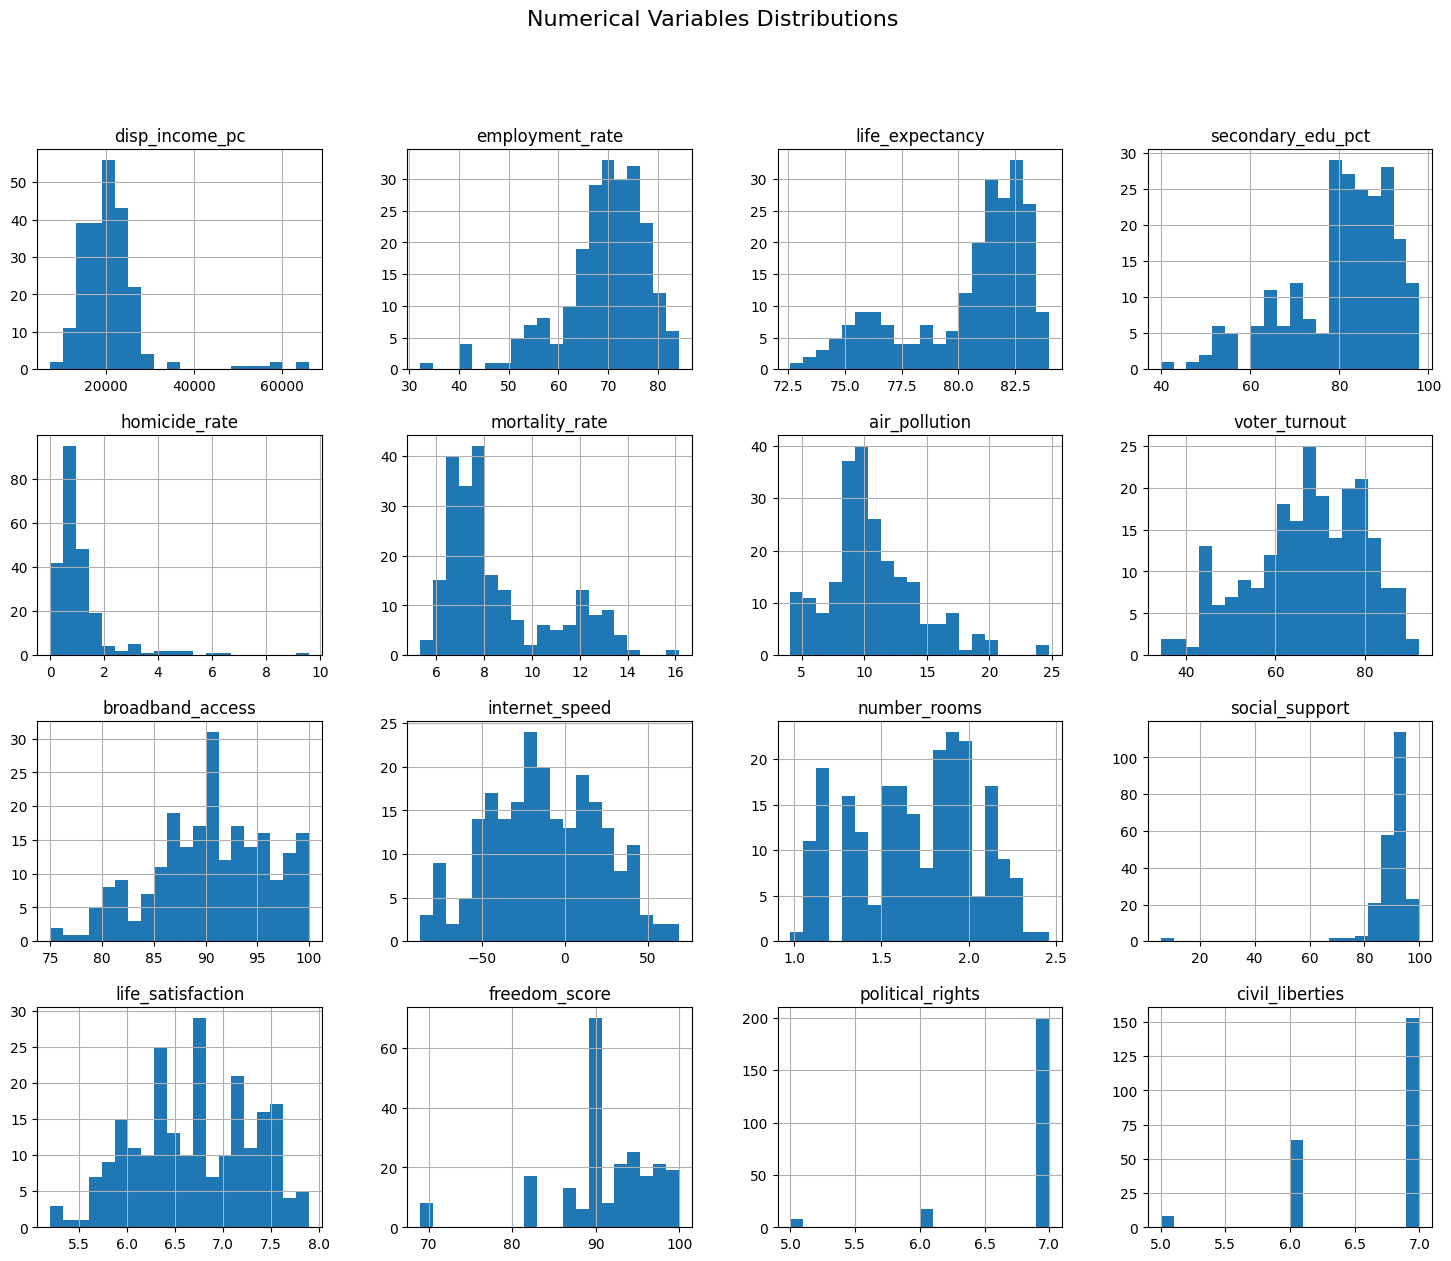

In [8]:
df_imputed[num_cols].hist(bins=20, figsize=(18,14))
plt.suptitle("Numerical Variables Distributions", fontsize=16)
plt.show()

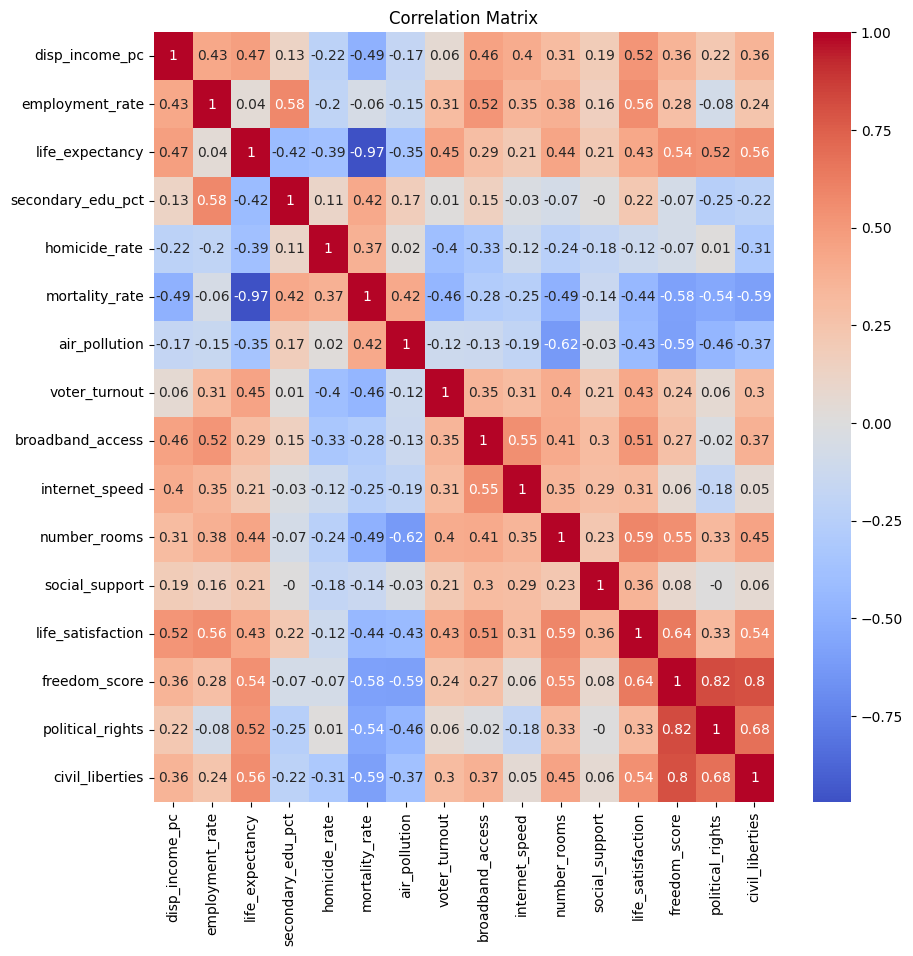

In [9]:
plt.figure(figsize=(10,10))
corr = round(df_imputed[num_cols].corr(),2)
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

### Definition Est/Ovest

In [10]:
east = df_imputed[df_imputed["macro_area"] == "East"]
west = df_imputed[df_imputed["macro_area"] == "West"]

print("Number of Eastern regions:", east.shape[0])
print("Number of Western regions:", west.shape[0])

Number of Eastern regions: 60
Number of Western regions: 165


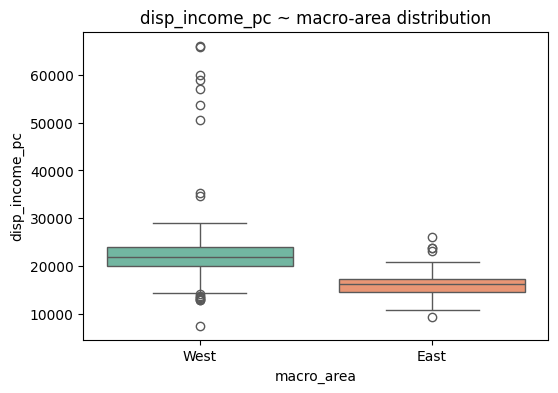

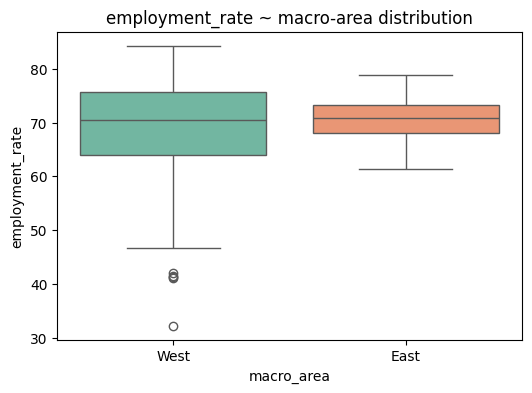

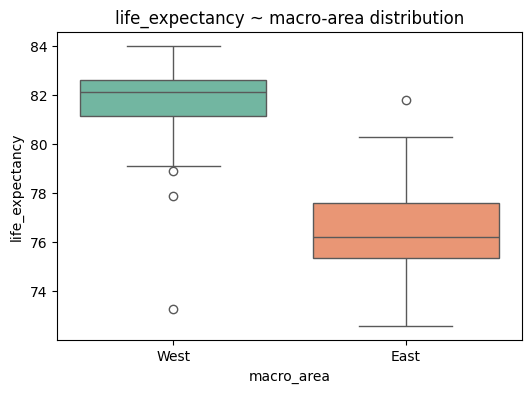

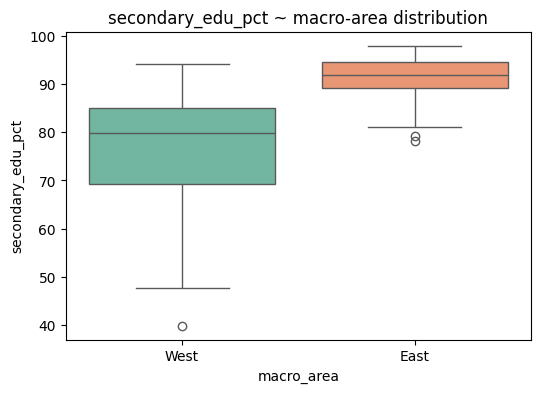

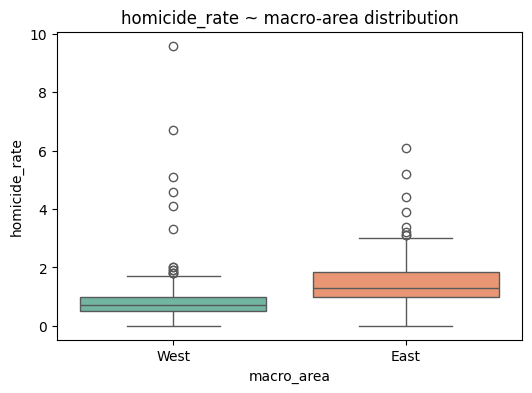

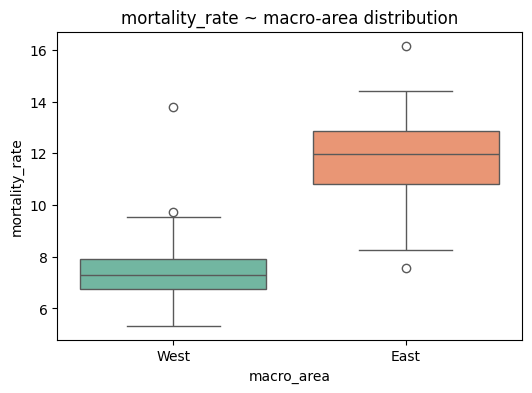

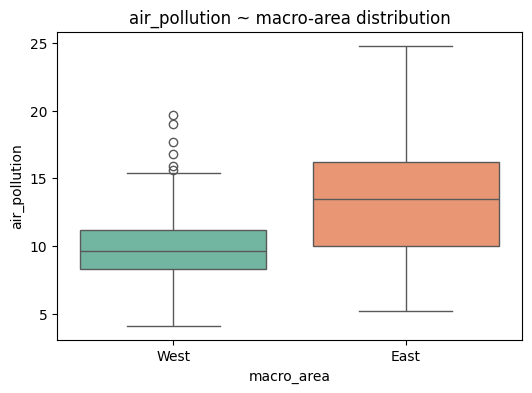

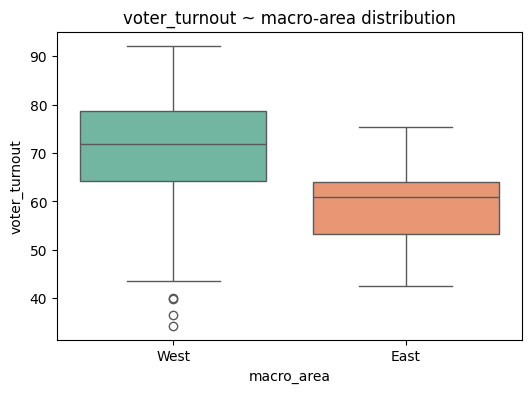

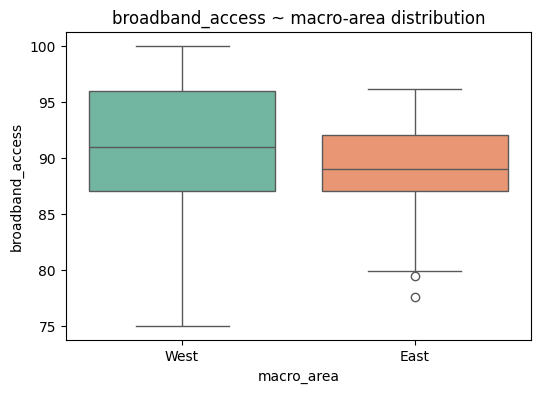

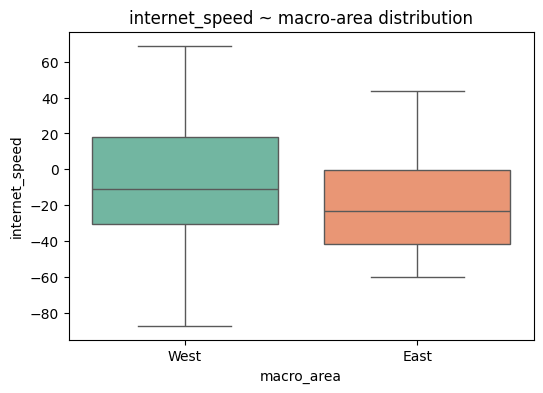

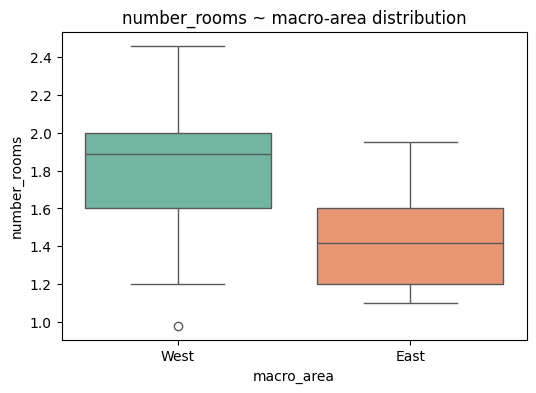

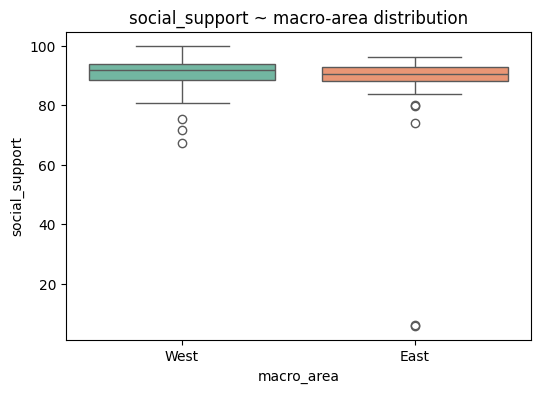

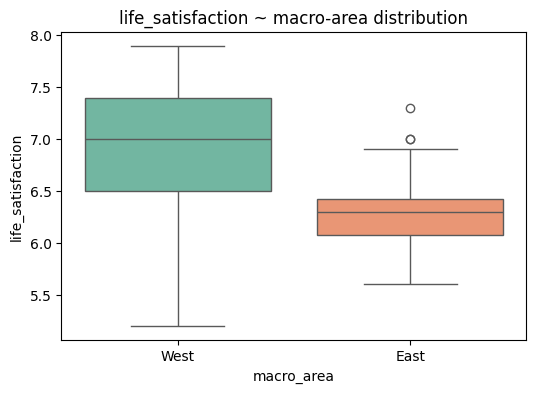

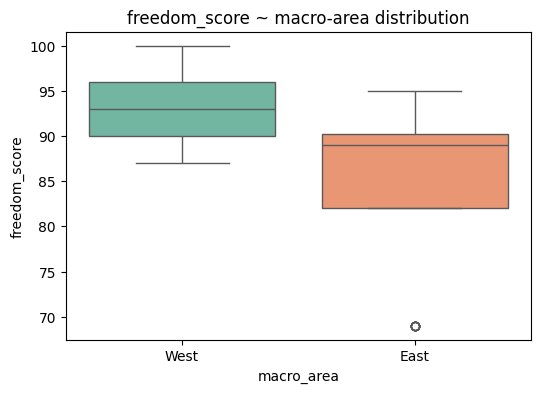

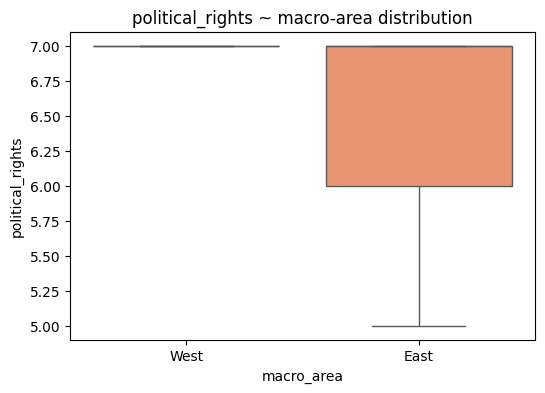

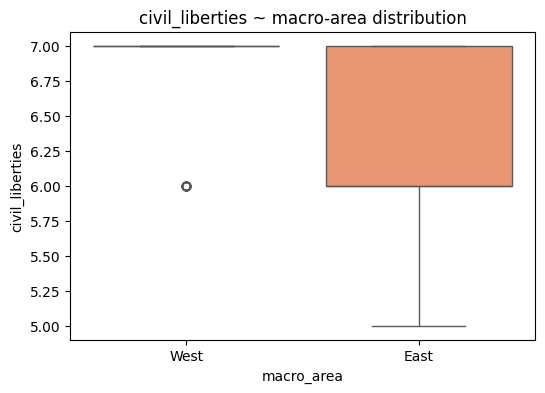

In [11]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="macro_area", y=col, data=df_merged, palette="Set2", hue='macro_area', legend=False)
    plt.title(f"{col} ~ macro-area distribution")
    plt.show()

In [12]:
results = []
for col in num_cols:
    east_vals = east[col].dropna()
    west_vals = west[col].dropna()

    # t-test
    t_stat, t_p = ttest_ind(east_vals, west_vals, equal_var=False)

    # Mann-Whitney (non parametric)
    mw_stat, mw_p = mannwhitneyu(east_vals, west_vals, alternative="two-sided")

    results.append({
        "variable": col,
        "mean_East": east_vals.mean(),
        "mean_West": west_vals.mean(),
        "t_test_p": t_p,
        "mannwhitney_p": mw_p
    })

stats_df = pd.DataFrame(results)
stats_df.sort_values("t_test_p", inplace=True)
stats_df.head(10)


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


variable     mean_East     mean_West      t_test_p  mannwhitney_p
2     life_expectancy     76.494167     81.837879  2.046027e-36   1.496265e-28
5      mortality_rate     11.783000      7.411212  2.445231e-33   1.662276e-28
3   secondary_edu_pct     91.235350     76.758182  7.478254e-32   2.970907e-22
10       number_rooms      1.399500      1.807897  4.325986e-19   2.055713e-15
0      disp_income_pc  16205.283333  23057.484848  4.593650e-16   5.297351e-16
12  life_satisfaction      6.285000      6.847879  3.076435e-15   4.628974e-11
7       voter_turnout     58.880500     70.228545  1.424151e-12   2.101996e-11
13      freedom_score     85.466667     93.315152  1.360329e-10   8.675918e-13
15    civil_liberties      6.183333      6.812121  7.918155e-10   2.313005e-13
6       air_pollution     13.263333      9.723030  8.505745e-08   9.505454e-09

In [13]:
mean_comparison = df_imputed.groupby("macro_area")[num_cols].mean().T


mean_comparison_norm = mean_comparison.copy()
for col in mean_comparison.index:
    min_val = df_imputed[col].min()
    max_val = df_imputed[col].max()
    mean_comparison_norm.loc[col] = (mean_comparison.loc[col] - min_val) / (max_val - min_val)

mean_comparison_norm["diff_East_minus_West_norm"] = (
    mean_comparison_norm["East"] - mean_comparison_norm["West"]
)


mean_comparison_norm.sort_values("diff_East_minus_West_norm", ascending=False, inplace=True)

mean_comparison_norm.head(10)

macro_area             East      West  diff_East_minus_West_norm
mortality_rate     0.595845  0.192171                   0.403674
secondary_edu_pct  0.883769  0.635020                   0.248749
air_pollution      0.442673  0.271644                   0.171029
homicide_rate      0.169618  0.095391                   0.074227
employment_rate    0.738996  0.700029                   0.038966
social_support     0.863747  0.904639                  -0.040891
internet_speed     0.428781  0.502188                  -0.073406
broadband_access   0.556867  0.637406                  -0.080539
disp_income_pc     0.149172  0.265947                  -0.116774
voter_turnout      0.424330  0.620629                  -0.196299

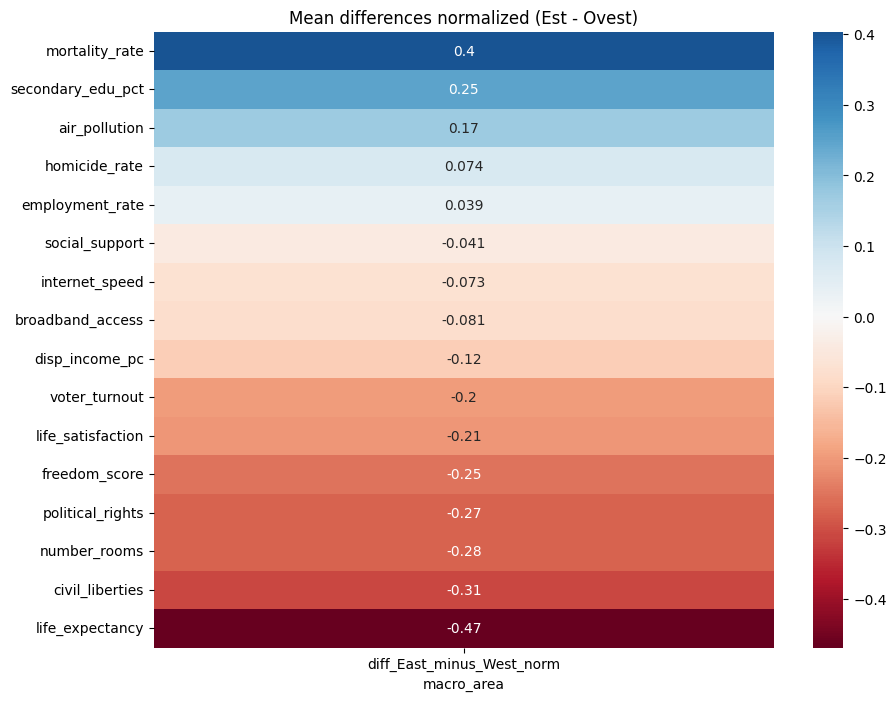

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(mean_comparison_norm[["diff_East_minus_West_norm"]], annot=True, cmap="RdBu", center=0)
plt.title("Mean differences normalized (Est - Ovest)")
plt.show()

In [15]:
print("Variables with statistically significant differences (p < 0.05):")
significant = (
    stats_df[stats_df["t_test_p"] < 0.05]
    [["variable", "mean_East", "mean_West", "t_test_p"]]
    .sort_values("t_test_p")
)
display(significant)

Variables with statistically significant differences (p < 0.05):


variable     mean_East     mean_West      t_test_p
2     life_expectancy     76.494167     81.837879  2.046027e-36
5      mortality_rate     11.783000      7.411212  2.445231e-33
3   secondary_edu_pct     91.235350     76.758182  7.478254e-32
10       number_rooms      1.399500      1.807897  4.325986e-19
0      disp_income_pc  16205.283333  23057.484848  4.593650e-16
12  life_satisfaction      6.285000      6.847879  3.076435e-15
7       voter_turnout     58.880500     70.228545  1.424151e-12
13      freedom_score     85.466667     93.315152  1.360329e-10
15    civil_liberties      6.183333      6.812121  7.918155e-10
6       air_pollution     13.263333      9.723030  8.505745e-08
14   political_rights      6.450000      7.000000  1.955230e-07
4       homicide_rate      1.628333      0.915758  8.537009e-05
8    broadband_access     88.921667     90.935152  4.506829e-03
9      internet_speed    -20.239286     -8.784803  1.167975e-02
1     employment_rate     70.701667     68.671515  2.962522e-02

Variance explained by the two principal components: [0.37067821 0.16389471]
Total explained variance: 0.53


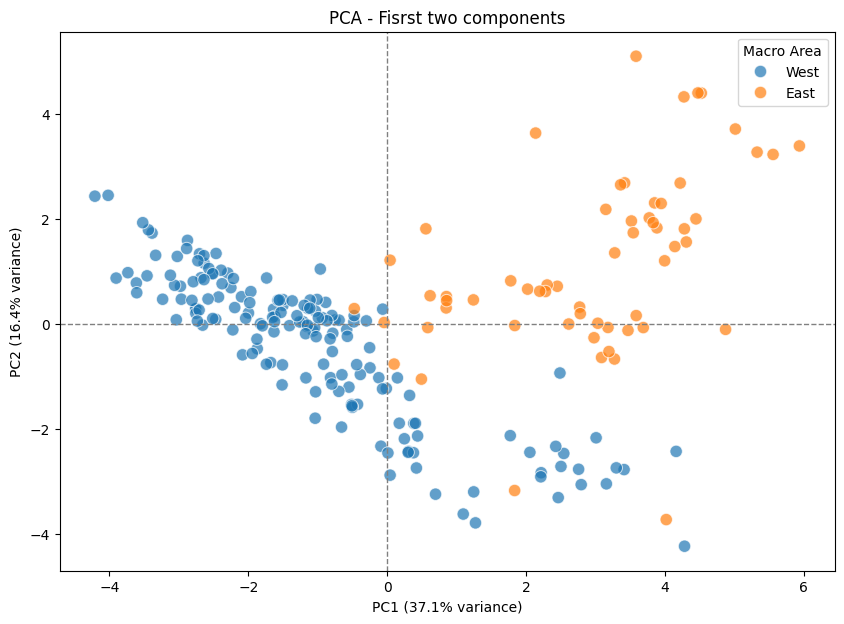

In [16]:
features = num_cols

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed[features])


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


df_imputed['PC1'] = X_pca[:, 0]
df_imputed['PC2'] = X_pca[:, 1]


explained_var = pca.explained_variance_ratio_
print(f"Variance explained by the two principal components: {explained_var}")
print(f"Total explained variance: {explained_var.sum():.2f}")

plt.figure(figsize=(10,7))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='macro_area',
    data=df_imputed,
    palette='tab10',
    s=80,
    alpha=0.7
)
plt.title("PCA - Fisrst two components")
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({explained_var[1]*100:.1f}% variance)")
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
plt.legend(title='Macro Area')
plt.show()

## **KMEANS**

Number of components: 7
Cumulative variance: 0.8682797694012894


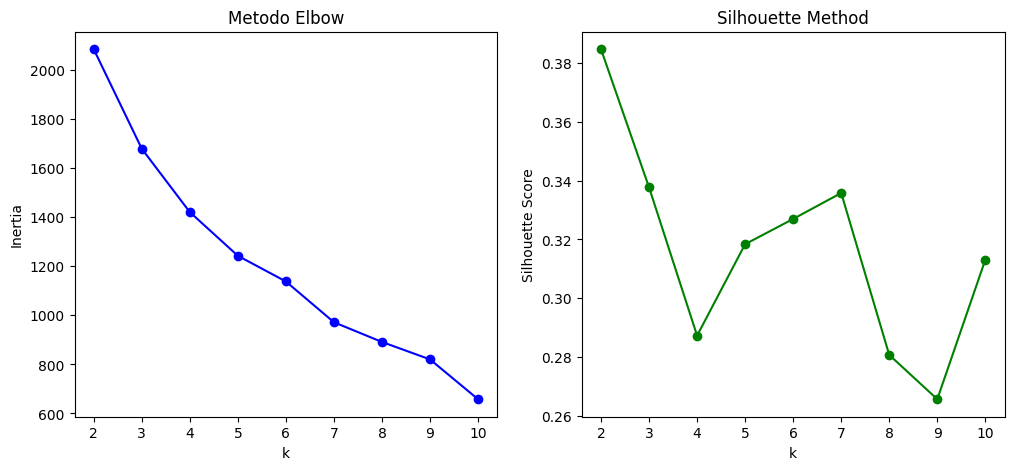

Optimal number of clusters: 2


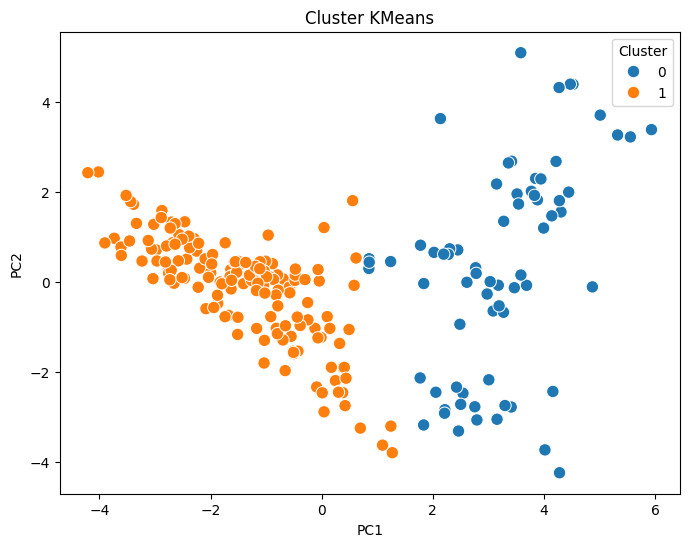

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed[num_cols])



pca = PCA(n_components=0.85, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

print("Number of components:", pca.n_components_)
print("Cumulative variance:", pca.explained_variance_ratio_.cumsum()[-1])


inertia_list = []
silhouette_list = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    inertia_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(X_pca, labels))


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia_list, 'o-', color='blue')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Metodo Elbow')

plt.subplot(1,2,2)
plt.plot(K_range, silhouette_list, 'o-', color='green')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')

plt.show()

k_opt = K_range[np.argmax(silhouette_list)]
print("Optimal number of clusters:", k_opt)


kmeans_final = KMeans(n_clusters=k_opt, random_state=42)
df_imputed['cluster'] = kmeans_final.fit_predict(X_pca)


plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_imputed['cluster'], palette='tab10', s=80)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cluster KMeans')
plt.legend(title='Cluster')
plt.show()

In [18]:
df_norm = df_imputed[num_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

cluster_means_norm = df_norm.groupby(df_imputed['cluster']).mean()
cluster_diff = (cluster_means_norm.max() - cluster_means_norm.min()).sort_values(ascending=False)

#Loading: shows the contribution of a variable to a component.
loadings_df = pd.DataFrame(pca.components_.T, index=num_cols, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
loadings_df['PC1_abs'] = loadings_df['PC1'].abs()
loadings_df['PC2_abs'] = loadings_df['PC2'].abs()

discriminant_vars = pd.DataFrame({
    'Max cluster diff (normalized)': cluster_diff,
    'PC1 loading': loadings_df['PC1'],
    'PC2 loading': loadings_df['PC2'],
    'PC1 loading abs': loadings_df['PC1_abs'],
    'PC2 loading abs': loadings_df['PC2_abs']
})


discriminant_vars = discriminant_vars.sort_values('Max cluster diff (normalized)', ascending=False)


print("Top 10 most discriminant variables among clusters:")
display(discriminant_vars.head(10))

Top 10 most discriminant variables among clusters:


Max cluster diff (normalized)  PC1 loading  PC2 loading  \
civil_liberties                         0.433389    -0.317549    -0.168464   
life_expectancy                         0.392737    -0.323691    -0.192220   
mortality_rate                          0.356867     0.334319     0.198645   
number_rooms                            0.322025    -0.304370     0.053455   
freedom_score                           0.282753    -0.329424    -0.179929   
life_satisfaction                       0.277520    -0.318713     0.177798   
voter_turnout                           0.259527    -0.216981     0.135926   
political_rights                        0.239130    -0.238864    -0.381579   
broadband_access                        0.196469    -0.235384     0.336546   
air_pollution                           0.190722     0.237067     0.146571   

                   PC1 loading abs  PC2 loading abs  
civil_liberties           0.317549         0.168464  
life_expectancy           0.323691         0.192220  
mortality_rate            0.334319         0.198645  
number_rooms              0.304370         0.053455  
freedom_score             0.329424         0.179929  
life_satisfaction         0.318713         0.177798  
voter_turnout             0.216981         0.135926  
political_rights          0.238864         0.381579  
broadband_access          0.235384         0.336546  
air_pollution             0.237067         0.146571

In [19]:
cluster_means = df_imputed.groupby('cluster')[num_cols].mean()

diff = (cluster_means.iloc[1] - cluster_means.iloc[0])
cluster_means.loc['Diff (c1 - c0)'] = diff
diff_pct= (diff / cluster_means.iloc[0]) * 100
diff_pct_formatted = diff_pct.apply(lambda x: f"{x:.2f}%")

cluster_means.loc['Diff (%)'] = diff_pct_formatted

print("Means and difference between the two clusters:")
display(cluster_means)

Means and difference between the two clusters:


disp_income_pc employment_rate life_expectancy  \
cluster                                                         
0                15633.710145       65.969565       77.308696   
1                23705.615385       70.647436       81.785897   
Diff (c1 - c0)     8071.90524        4.677871        4.477202   
Diff (%)               51.63%           7.09%           5.79%   

               secondary_edu_pct homicide_rate mortality_rate air_pollution  \
cluster                                                                       
0                      86.567406      1.789855      11.256667     13.404348   
1                      77.987628      0.803205       7.391795       9.45641   
Diff (c1 - c0)         -8.579778      -0.98665      -3.864872     -3.947938   
Diff (%)                  -9.91%       -55.12%        -34.33%       -29.45%   

               voter_turnout broadband_access internet_speed number_rooms  \
cluster                                                                     
0                  56.800145        86.992754     -30.868449     1.368551   
1                  71.803397        91.904487      -3.422607     1.845147   
Diff (c1 - c0)     15.003253         4.911734      27.445842     0.476597   
Diff (%)              26.41%            5.65%        -88.91%       34.82%   

               social_support life_satisfaction freedom_score  \
cluster                                                         
0                   85.884058          6.178261     85.144928   
1                   91.805769          6.927564     93.910256   
Diff (c1 - c0)       5.921711          0.749303      8.765329   
Diff (%)                6.90%            12.13%        10.29%   

               political_rights civil_liberties  
cluster                                          
0                      6.521739        6.043478  
1                           7.0        6.910256  
Diff (c1 - c0)         0.478261        0.866778  
Diff (%)                  7.33%          14.34%

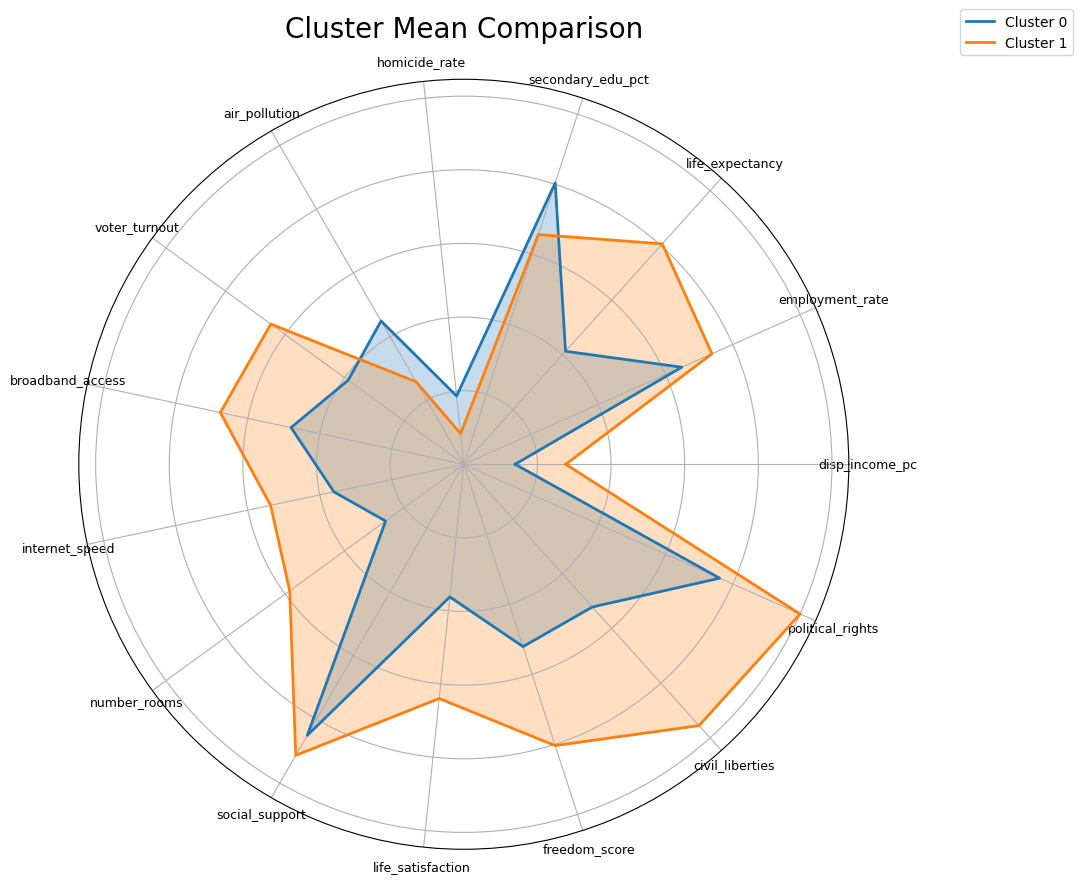

In [20]:
vars_to_plot = [
    "disp_income_pc", "employment_rate", "life_expectancy",
    "secondary_edu_pct", "homicide_rate", "air_pollution",
    "voter_turnout", "broadband_access", "internet_speed", "number_rooms",
    "social_support", "life_satisfaction", "freedom_score", 'civil_liberties', 'political_rights'
]


cluster_means = df_imputed.groupby('cluster')[vars_to_plot].mean()


cluster_norm = cluster_means.copy()
for col in vars_to_plot:
    min_val = df_imputed[col].min()
    max_val = df_imputed[col].max()
    cluster_norm[col] = (cluster_means[col] - min_val) / (max_val - min_val)


num_vars = len(vars_to_plot)


angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]


fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(polar=True))


colors = ['#1f77b4', '#ff7f0e']

for i, (idx, row) in enumerate(cluster_norm.iterrows()):
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, color=colors[i], label=f'Cluster {idx}')
    ax.fill(angles, values, color=colors[i], alpha=0.25)


ax.set_xticks(angles[:-1])
ax.set_xticklabels(vars_to_plot, fontsize=9)


ax.set_yticklabels([])


ax.set_title("Cluster Mean Comparison", fontsize=20, pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()

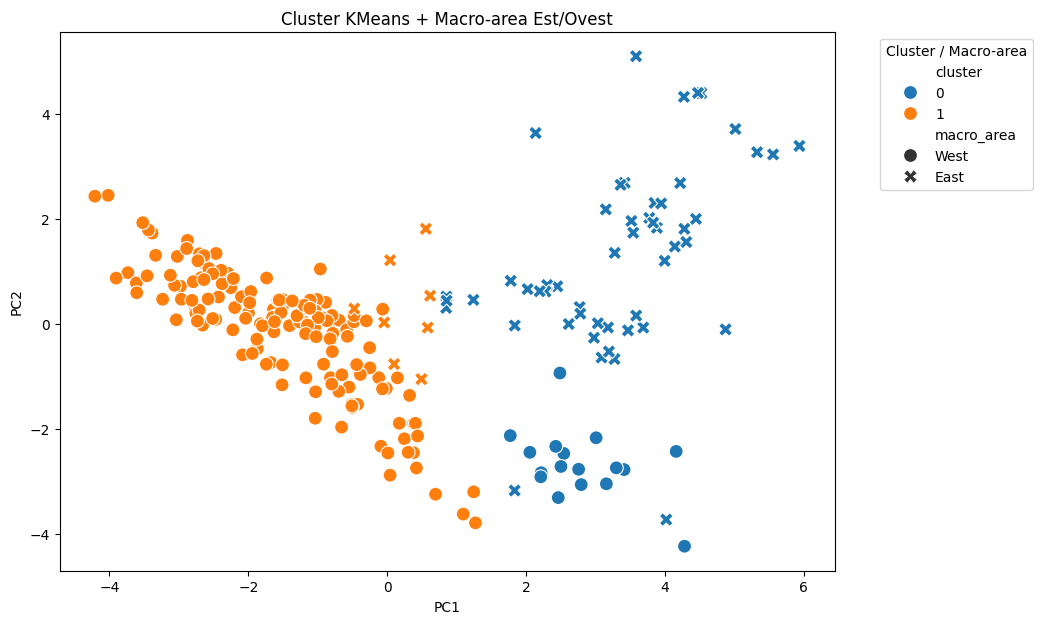

In [21]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=df_imputed['cluster'],
    style=df_imputed['macro_area'],
    palette='tab10',
    s=100
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cluster KMeans + Macro-area Est/Ovest')
plt.legend(title='Cluster / Macro-area', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

Counts per cluster / macro-area:
macro_area  East  West
cluster               
0             52    17
1              8   148

Percentages per cluster / macro-area:
macro_area    East    West
cluster                   
0           75.36%  24.64%
1            5.13%  94.87%


/tmp/ipython-input-3918444969.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cluster_macro_pct_str = cluster_macro_pct.applymap(lambda y: f"{y:.2f}%")


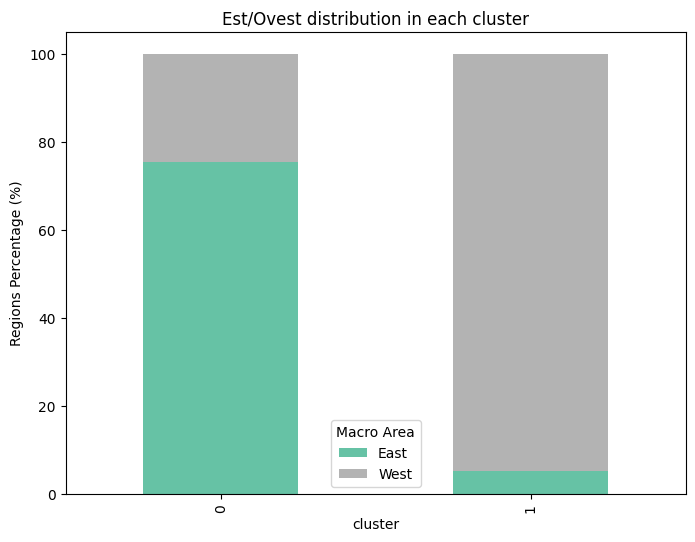

In [22]:

cluster_macro_dist = df_imputed.groupby(['cluster', 'macro_area']).size().unstack(fill_value=0)

cluster_macro_pct = cluster_macro_dist.div(cluster_macro_dist.sum(axis=1), axis=0) * 100
cluster_macro_pct_str = cluster_macro_pct.applymap(lambda y: f"{y:.2f}%")

print("Counts per cluster / macro-area:")
print(cluster_macro_dist)
print("\nPercentages per cluster / macro-area:")
print(cluster_macro_pct_str)

ax = cluster_macro_pct.plot(kind='bar', stacked=True, figsize=(8,6), colormap='Set2')

plt.ylabel('Regions Percentage (%)')
plt.title('Est/Ovest distribution in each cluster')
plt.legend(title="Macro Area")
plt.show()


In [23]:
purity = cluster_macro_dist.max(axis=1).sum() / cluster_macro_dist.sum().sum()
print(f"Clustering purity: {purity:.2f}")

Clustering purity: 0.89


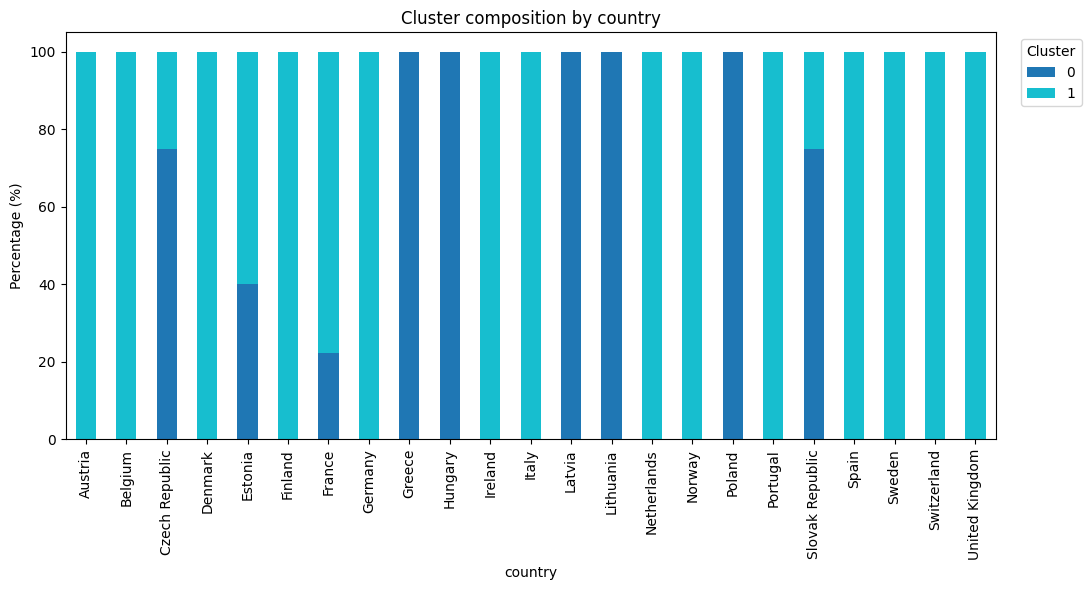

In [24]:
counts = df_imputed.groupby(['country','cluster']).size().unstack(fill_value=0)
counts = counts[counts.sum(axis=1)>=3]
(counts.div(counts.sum(axis=1), axis=0)*100).plot(kind='bar', stacked=True, figsize=(11,6), colormap='tab10')
plt.ylabel('Percentage (%)')
plt.title('Cluster composition by country')
plt.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

### **Bridge regions**

In [25]:
dom = (df_imputed.groupby(['cluster','macro_area']).size()
       .reset_index(name='n'))
dom = dom.loc[dom.groupby('cluster')['n'].idxmax(), ['cluster','macro_area']]
dom = dom.rename(columns={'macro_area':'cluster_dominant_area'})

df_bridge = df_imputed[['country','region','macro_area','cluster']].merge(dom, on='cluster', how='left')
df_bridge['is_bridge'] = df_bridge['macro_area'] != df_bridge['cluster_dominant_area']

bridge_regions = df_bridge[df_bridge['is_bridge']].copy()
print(f"Bridge Regions: {len(bridge_regions)}")
display(bridge_regions.sort_values(['cluster','country','region']).head(30))

Bridge Regions: 25


country                     region macro_area  cluster  \
50            France              French Guiana       West        0   
48            France                 Guadeloupe       West        0   
49            France                 Martinique       West        0   
52            France                    Mayotte       West        0   
69            Greece                     Attica       West        0   
80            Greece             Central Greece       West        0   
74            Greece          Central Macedonia       West        0   
72            Greece                      Crete       West        0   
73            Greece  Eastern Macedonia, Thrace       West        0   
76            Greece                     Epirus       West        0   
78            Greece             Ionian Islands       West        0   
70            Greece               North Aegean       West        0   
81            Greece                Peloponnese       West        0   
71            Greece               South Aegean       West        0   
77            Greece                   Thessaly       West        0   
79            Greece             Western Greece       West        0   
75            Greece          Western Macedonia       West        0   
12    Czech Republic                     Prague       East        1   
14    Czech Republic                  Southwest       East        1   
25           Estonia              North Estonia       East        1   
27           Estonia           Southern Estonia       East        1   
26           Estonia               West Estonia       East        1   
175  Slovak Republic                 Bratislava       East        1   
179         Slovenia           Eastern Slovenia       East        1   
180         Slovenia           Western Slovenia       East        1   

    cluster_dominant_area  is_bridge  
50                   East       True  
48                   East       True  
49                   East       True  
52                   East       True  
69                   East       True  
80                   East       True  
74                   East       True  
72                   East       True  
73                   East       True  
76                   East       True  
78                   East       True  
70                   East       True  
81                   East       True  
71                   East       True  
77                   East       True  
79                   East       True  
75                   East       True  
12                   West       True  
14                   West       True  
25                   West       True  
27                   West       True  
26                   West       True  
175                  West       True  
179                  West       True  
180                  West       True

In [26]:
pca_space = pd.DataFrame(X_pca, index=df_imputed.index)
pca_space['cluster'] = df_imputed['cluster'].values

centroids = pca_space.groupby('cluster').mean().drop(columns=['cluster'], errors='ignore').values

dist_to_centroid = []
for i,(idx,row) in enumerate(pca_space.drop(columns=['cluster']).iterrows()):
    k = pca_space.loc[idx,'cluster']
    d = norm(row.values - centroids[k])
    dist_to_centroid.append(d)
df_imputed['dist_to_centroid'] = dist_to_centroid

bridge_scored = df_imputed.merge(bridge_regions[['country','region']], on=['country','region'])
bridge_scored = bridge_scored[['country','region','macro_area','cluster','dist_to_centroid']] \
                           .sort_values('dist_to_centroid')
print("Most Central Bridge Regions (potential avanguards):")
display(bridge_scored.head(20))

Most Central Bridge Regions (potential avanguards):


country                     region macro_area  cluster  \
2           Estonia              North Estonia       East        1   
24         Slovenia           Western Slovenia       East        1   
9            Greece                     Attica       West        0   
4           Estonia           Southern Estonia       East        1   
0    Czech Republic                     Prague       East        1   
14           Greece          Central Macedonia       West        0   
23         Slovenia           Eastern Slovenia       East        1   
3           Estonia               West Estonia       East        1   
1    Czech Republic                  Southwest       East        1   
21           Greece                Peloponnese       West        0   
10           Greece               North Aegean       West        0   
22  Slovak Republic                 Bratislava       East        1   
18           Greece             Ionian Islands       West        0   
11           Greece               South Aegean       West        0   
12           Greece                      Crete       West        0   
13           Greece  Eastern Macedonia, Thrace       West        0   
19           Greece             Western Greece       West        0   
17           Greece                   Thessaly       West        0   
15           Greece          Western Macedonia       West        0   
20           Greece             Central Greece       West        0   

    dist_to_centroid  
2           2.121210  
24          2.127195  
9           2.388732  
4           2.797941  
0           2.803905  
14          3.002653  
23          3.038572  
3           3.085784  
1           3.137237  
21          3.163738  
10          3.399148  
22          3.403627  
18          3.458089  
11          3.525486  
12          3.561557  
13          3.661718  
19          3.675327  
17          3.981398  
15          4.021904  
20          4.102619

KMEANS WITHOUT FREEDOM: To assess the role of institutional variables in shaping the clusters, we repeated the clustering pipeline after removing political freedom indicators. We compared the resulting partitions using the Adjusted Rand Index and identified the regions whose cluster membership changed. This robustness check provided insights into the relative importance of institutional factors compared to structural socio-economic ones.

In [27]:
if 'k_opt' not in globals():
    scaler_tmp = StandardScaler().fit(df_imputed[num_cols])
    Xs = scaler_tmp.transform(df_imputed[num_cols])
    pca_tmp = PCA(n_components=0.85, svd_solver='full').fit(Xs)
    Xp = pca_tmp.transform(Xs)
    sils = []
    K_range = range(2, 11)
    for k in K_range:
        sils.append(silhouette_score(Xp, KMeans(n_clusters=k, random_state=42).fit_predict(Xp)))
    k_opt = K_range[int(np.argmax(sils))]
    print("k_opt (ricalcolato):", k_opt)


features_with = num_cols[:]
sc_with = StandardScaler().fit(df_imputed[features_with])
Xp_with = PCA(n_components=0.85, svd_solver='full').fit_transform(sc_with.transform(df_imputed[features_with]))
km_with = KMeans(n_clusters=k_opt, random_state=42).fit(Xp_with)
labels_with = km_with.labels_


drop_fh = ['freedom_score','political_rights','civil_liberties']
features_wo = [c for c in features_with if c not in drop_fh]
sc_wo = StandardScaler().fit(df_imputed[features_wo])
Xp_wo = PCA(n_components=0.85, svd_solver='full').fit_transform(sc_wo.transform(df_imputed[features_wo]))
km_wo = KMeans(n_clusters=k_opt, random_state=42).fit(Xp_wo)
labels_wo = km_wo.labels_


ari = adjusted_rand_score(labels_with, labels_wo)
print(f"Adjusted Rand Index (with vs without): {ari:.3f}")

cm = confusion_matrix(labels_with, labels_wo)
cm_df = pd.DataFrame(cm, index=[f'with_{i}' for i in range(k_opt)], columns=[f'wo_{j}' for j in range(k_opt)])
print("Cluster confusion (with vs without):")
display(cm_df)


changed = np.where(labels_with != labels_wo)[0]
changed_df = df_imputed.iloc[changed][['country','region','macro_area']].copy()
changed_df['k_with'] = labels_with[changed]
changed_df['k_wo'] = labels_wo[changed]
print(f"Regions that change cluster: {len(changed_df)}")
display(changed_df.head(20))

Adjusted Rand Index (with vs without): 0.702
Cluster confusion (with vs without):


wo_0  wo_1
with_0    68     1
with_1    17   139

Regions that change cluster: 18


country                       region macro_area  k_with  k_wo
14    Czech Republic                    Southwest       East       1     0
25           Estonia                North Estonia       East       1     0
26           Estonia                 West Estonia       East       1     0
27           Estonia             Southern Estonia       East       1     0
57           Germany                       Bremen       West       1     0
82           Hungary                     Budapest       East       0     1
101            Italy                     Campania       West       1     0
102            Italy                       Apulia       West       1     0
103            Italy                   Basilicata       West       1     0
104            Italy                     Calabria       West       1     0
105            Italy                       Sicily       West       1     0
169         Portugal                      Algarve       West       1     0
170         Portugal             Central Portugal       West       1     0
172         Portugal                     Alentejo       West       1     0
173         Portugal   Azores (autonomous region)       West       1     0
174         Portugal  Madeira (autonomous region)       West       1     0
175  Slovak Republic                   Bratislava       East       1     0
179         Slovenia             Eastern Slovenia       East       1     0

###**DBSCAN**

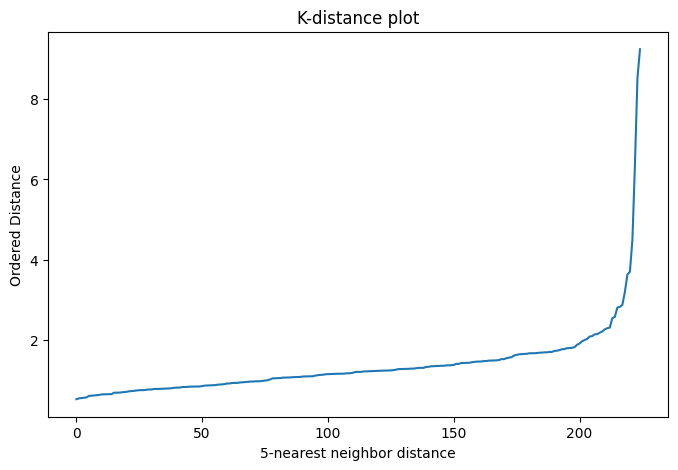

In [28]:
neighbors = 5
nbrs = NearestNeighbors(n_neighbors=neighbors)
nbrs.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)


k_distances = np.sort(distances[:, neighbors-1])
plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.xlabel(f'{neighbors}-nearest neighbor distance')
plt.ylabel('Ordered Distance')
plt.title('K-distance plot')
plt.show()

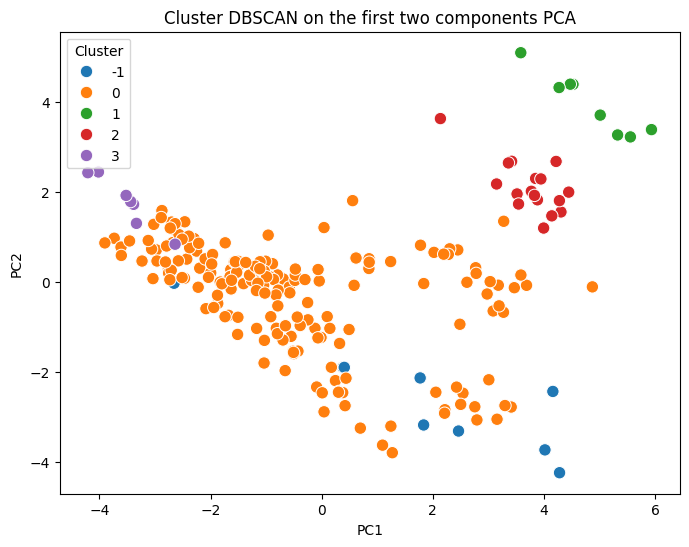

In [29]:
eps_val = 2.25
min_samples_val = 5

dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val)
df_imputed['dbscan_cluster'] = dbscan.fit_predict(X_pca)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=df_imputed['dbscan_cluster'],
    palette='tab10',
    s=80
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cluster DBSCAN on the first two components PCA')
plt.legend(title='Cluster')
plt.show()

In [30]:
count_macro = pd.crosstab(df_imputed['dbscan_cluster'], df_imputed['macro_area'])
print("Counts per cluster / macro-area:")
display(count_macro)

perc_macro = count_macro.div(count_macro.sum(axis=1), axis=0) * 100
perc_macro_formatted = perc_macro.applymap(lambda x: f"{x:.2f}%")

print("Percentages per cluster / macro-area (formatted):")
display(perc_macro_formatted)

Counts per cluster / macro-area:


macro_area      East  West
dbscan_cluster            
-1                 2     7
 0                33   151
 1                 8     0
 2                17     0
 3                 0     7

Percentages per cluster / macro-area (formatted):


/tmp/ipython-input-2031283061.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  perc_macro_formatted = perc_macro.applymap(lambda x: f"{x:.2f}%")


macro_area         East     West
dbscan_cluster                  
-1               22.22%   77.78%
 0               17.93%   82.07%
 1              100.00%    0.00%
 2              100.00%    0.00%
 3                0.00%  100.00%

In [31]:
cluster_means_dbscan = df_imputed.groupby('dbscan_cluster')[num_cols].mean()
print(" Cluster Means (DBSCAN):")
display(cluster_means_dbscan)

 Cluster Means (DBSCAN):


disp_income_pc  employment_rate  life_expectancy  \
dbscan_cluster                                                     
-1                16755.333333        56.955556        79.816667   
 0                20692.347826        69.234783        80.907880   
 1                15001.125000        72.712500        75.612500   
 2                16841.117647        69.911765        76.500000   
 3                58900.571429        78.700000        83.157143   

                secondary_edu_pct  homicide_rate  mortality_rate  \
dbscan_cluster                                                     
-1                      72.603333       4.677778        8.821111   
 0                      79.416255       0.944022        8.182337   
 1                      85.637500       0.712500       12.696250   
 2                      92.776471       1.417647       11.777647   
 3                      87.271429       0.457143        6.157143   

                air_pollution  voter_turnout  broadband_access  \
dbscan_cluster                                                   
-1                   8.033333      48.998889         83.055556   
 0                  10.095652      69.419620         90.379348   
 1                  14.112500      70.086250         90.500000   
 2                  17.094118      60.082353         90.958824   
 3                   9.528571      46.321429         98.857143   

                internet_speed  number_rooms  social_support  \
dbscan_cluster                                                 
-1                  -31.742283      1.637778       74.144444   
 0                  -14.971016      1.752897       90.737500   
 1                   15.763327      1.575000       92.987500   
 2                   -1.299509      1.158824       87.329412   
 3                   38.926120      1.814286       93.742857   

                life_satisfaction  freedom_score  political_rights  \
dbscan_cluster                                                       
-1                       6.677778      92.000000               7.0   
 0                       6.747826      92.820652               7.0   
 1                       6.050000      69.000000               5.0   
 2                       6.147059      82.000000               6.0   
 3                       7.485714      96.000000               7.0   

                civil_liberties  
dbscan_cluster                   
-1                     6.333333  
 0                     6.777174  
 1                     5.000000  
 2                     6.000000  
 3                     7.000000

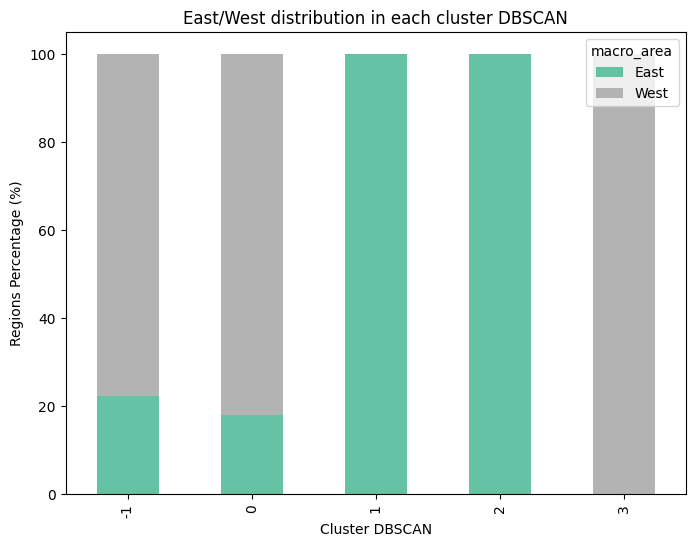

clustering purity: 0.84


In [32]:
dbscan_counts = pd.crosstab(df_imputed['dbscan_cluster'], df_imputed['macro_area'])


dbscan_pct = dbscan_counts.div(dbscan_counts.sum(axis=1), axis=0) * 100


ax = dbscan_pct.plot(kind='bar', stacked=True, figsize=(8,6), colormap='Set2')



plt.ylabel('Regions Percentage (%)')
plt.xlabel('Cluster DBSCAN')
plt.title('East/West distribution in each cluster DBSCAN')
plt.show()


purity = dbscan_counts.max(axis=1).sum() / dbscan_counts.sum().sum()
print(f"clustering purity: {purity:.2f}")

In [33]:
if 'dbscan_cluster' in df_imputed.columns:
    outliers = df_imputed[df_imputed['dbscan_cluster'] == -1][['country','region','macro_area']]
    print(f"Outlier DBSCAN: {len(outliers)}")
    display(outliers.head(30))

Outlier DBSCAN: 9


country             region macro_area
28  Estonia    Central Estonia       East
29  Estonia  Northeast Estonia       East
34  Finland              Åland       West
47   France            Corsica       West
48   France         Guadeloupe       West
49   France         Martinique       West
50   France      French Guiana       West
51   France         La Réunion       West
52   France            Mayotte       West

### **INTERNAL COHESION**

Cohesion Index:


/tmp/ipython-input-3019811992.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_disp_pca = df_pca_space.groupby('country').apply(dispersion_to_centroid).reset_index()


country  dispersion_pca  avg_within_sd_z  cohesion_index
15       Luxembourg        0.000000         0.000000        0.000000
3           Denmark        0.508347         0.152668        0.330507
10          Iceland        0.566927         0.095631        0.331279
16      Netherlands        0.543883         0.148625        0.346254
17           Norway        0.588566         0.167373        0.377970
11          Ireland        0.607695         0.158328        0.383012
21         Slovenia        0.656971         0.141034        0.399002
0           Austria        0.593334         0.220050        0.406692
23           Sweden        0.714009         0.198046        0.456028
2    Czech Republic        0.879619         0.267424        0.573521
24      Switzerland        0.913944         0.234165        0.574054
25   United Kingdom        0.921045         0.259876        0.590461
5           Finland        0.947353         0.282540        0.614946
7           Germany        0.964087         0.290241        0.627164
20  Slovak Republic        1.134221         0.290953        0.712587
22            Spain        1.120671         0.321933        0.721302
9           Hungary        1.132020         0.313771        0.722895
14        Lithuania        1.175043         0.313521        0.744282
8            Greece        1.175387         0.315486        0.745437
18           Poland        1.226343         0.328596        0.777470
19         Portugal        1.231784         0.353554        0.792669
1           Belgium        1.318186         0.328337        0.823261
13           Latvia        1.371080         0.357088        0.864084
12            Italy        1.491037         0.383873        0.937455
6            France        2.735016         0.709541        1.722279
4           Estonia        4.841569         0.683138        2.762353

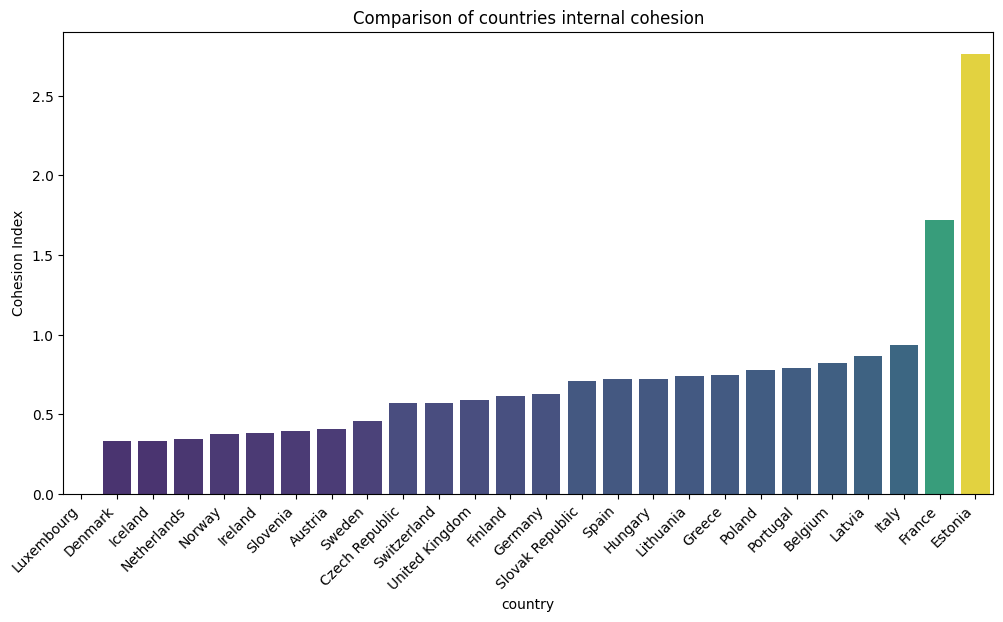

In [34]:
pca_cols = [f'PC{i+1}' for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=pca_cols, index=df_imputed.index)
df_pca_space = pd.concat([df_imputed[['country','region','macro_area']], X_pca_df], axis=1)

def dispersion_to_centroid(group):
    X = group[pca_cols].values
    centroid = X.mean(axis=0, keepdims=True)
    d = np.linalg.norm(X - centroid, axis=1)
    return pd.Series({'dispersion_pca': d.mean()})

country_disp_pca = df_pca_space.groupby('country').apply(dispersion_to_centroid).reset_index()


scaler_all = StandardScaler()
Z = pd.DataFrame(scaler_all.fit_transform(df_imputed[num_cols]), columns=num_cols, index=df_imputed.index)
Z_with_keys = pd.concat([df_imputed[['country','region']], Z], axis=1)

sd_intra = Z_with_keys.groupby('country')[num_cols].std(ddof=0)
country_disp_z = sd_intra.mean(axis=1).rename('avg_within_sd_z').reset_index()

country_cohesion = country_disp_pca.merge(country_disp_z, on='country', how='left')


country_cohesion['cohesion_index'] = country_cohesion[['dispersion_pca','avg_within_sd_z']].mean(axis=1)


country_cohesion_sorted = country_cohesion.sort_values('cohesion_index')

print("Cohesion Index:")
display(country_cohesion_sorted)


plt.figure(figsize=(12,6))
sns.barplot(x='country', y='cohesion_index', data=country_cohesion_sorted, palette='viridis', hue='cohesion_index', legend=False)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cohesion Index')
plt.title('Comparison of countries internal cohesion')
plt.show()


Here we investigate the differences in Europe after the inclusion of some countries

In [35]:
EU15 = {
    'Austria','Belgium','Denmark','Finland','France','Germany','Greece',
    'Ireland','Italy','Luxembourg','Netherlands','Portugal','Spain','Sweden','United Kingdom'
}
EU_POST2004 = {
    'Czech Republic','Estonia','Hungary','Latvia','Lithuania','Poland','Slovak Republic','Slovenia'
}

country_groups = df_imputed[['country']].drop_duplicates().copy()
def eu_group(c):
    if c in EU15: return 'EU15'
    if c in EU_POST2004: return 'EU post-2004'
    return 'Non-EU'
country_groups['eu_group'] = country_groups['country'].apply(eu_group)


country_fh = df_imputed.groupby('country')['freedom_score'].median().reset_index()
def fh_cat(score):
    if score >= 70: return 'Free'
    elif score >= 35: return 'Partly Free'
    else: return 'Not Free'
country_fh['fh_category'] = country_fh['freedom_score'].apply(fh_cat)


cohesion_groups = country_cohesion.merge(country_groups, on='country', how='left') \
                                  .merge(country_fh[['country','fh_category']], on='country', how='left')

print("Cohesion by EU group (mediane):")
display(cohesion_groups.groupby('eu_group')[['dispersion_pca','avg_within_sd_z']].median())

print("Cohesion by Freedom category (mediane):")
display(cohesion_groups.groupby('fh_category')[['dispersion_pca','avg_within_sd_z']].median())



def mann_whitney_report(data, group_col, metric, g1, g2):
    x = data.loc[data[group_col]==g1, metric].dropna()
    y = data.loc[data[group_col]==g2, metric].dropna()
    if len(x)>0 and len(y)>0:
        U,p = mannwhitneyu(x,y, alternative='two-sided')
        print(f"{metric}: {group_col} {g1} vs {g2} -> U={U:.1f}, p={p:.4f}, mediane=({x.median():.3f}, {y.median():.3f})")
    else:
        print(f"{metric}:insufficient groups for {g1} vs {g2}")

print("\n=== Mann-Whitney: EU15 vs EU post-2004 ===")
for m in ['dispersion_pca','avg_within_sd_z']:
    mann_whitney_report(cohesion_groups[cohesion_groups['eu_group']!='Non-EU'], 'eu_group', m, 'EU15', 'EU post-2004')

print("\n=== Mann-Whitney: Free vs Partly Free ===")
for m in ['dispersion_pca','avg_within_sd_z']:
    mann_whitney_report(cohesion_groups, 'fh_category', m, 'Free', 'Partly Free')


Cohesion by EU group (mediane):


dispersion_pca  avg_within_sd_z
eu_group                                     
EU post-2004        1.154632         0.313646
EU15                0.947353         0.282540
Non-EU              0.588566         0.167373

Cohesion by Freedom category (mediane):


dispersion_pca  avg_within_sd_z
fh_category                                 
Free               0.947353         0.282540
Partly Free        1.132020         0.313771


=== Mann-Whitney: EU15 vs EU post-2004 ===
dispersion_pca: eu_group EU15 vs EU post-2004 -> U=40.0, p=0.2132, mediane=(0.947, 1.155)
avg_within_sd_z: eu_group EU15 vs EU post-2004 -> U=46.0, p=0.3918, mediane=(0.283, 0.314)

=== Mann-Whitney: Free vs Partly Free ===
dispersion_pca: fh_category Free vs Partly Free -> U=10.0, p=0.8462, mediane=(0.947, 1.132)
avg_within_sd_z: fh_category Free vs Partly Free -> U=9.0, p=0.7692, mediane=(0.283, 0.314)


## **COUNTERFACTUAL ANALYSIS**

In [36]:
pio.renderers.default = "colab"

df_country_mean = df_imputed.groupby("country")[num_cols].mean().reset_index()

fig = px.choropleth(
    df_country_mean,
    locations="country",
    locationmode="country names",
    color="disp_income_pc",
    color_continuous_scale="Viridis",
    title="Disposable Income per capita"
)

fig.update_geos(
    projection_type="natural earth",
    fitbounds="locations",
    lataxis_range=[35, 70],
    lonaxis_range=[-15, 40]
)

fig.show(renderer="colab")

In [37]:
np.random.seed(42)
target_col = "disp_income_pc"
features_ext = [c for c in num_cols if c != target_col]


required_cols = features_ext + [target_col, 'cluster', 'macro_area', 'country', 'region']
mask = df_imputed[required_cols].notnull().all(axis=1)
df_model = df_imputed.loc[mask].copy().reset_index(drop=True)


num_cols_to_cast = features_ext + [target_col]
df_model[num_cols_to_cast] = df_model[num_cols_to_cast].astype(float)



east_mask = df_model['macro_area'] == 'East'
west_mask = df_model['macro_area'] == 'West'


X_all = df_model[features_ext].copy()
y_all = df_model[target_col]


rf_cv = RandomForestRegressor(n_estimators=800, max_features="sqrt", random_state=42, n_jobs=-1)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_cv, X_all, y_all, cv=kf, scoring='r2', n_jobs=-1)
print("\nCross-validation R² scores:", cv_scores)
print("Mean R²:", cv_scores.mean())


rf_full = RandomForestRegressor(n_estimators=800, max_features="sqrt", random_state=42, n_jobs=-1)
rf_full.fit(X_all, y_all)

# Permutation Importance
# Computes Permutation Importance = how much the performance decreases when a feature is shuffled.
# perm_mean: average importance
# perm_std: standard deviation of the importance
perm = permutation_importance(rf_full, X_all, y_all, n_repeats=20, random_state=42, n_jobs=-1)
pi = pd.DataFrame({
    "feature": X_all.columns,
    "perm_mean": perm.importances_mean,
    "perm_std": perm.importances_std
}).sort_values("perm_mean", ascending=False).reset_index(drop=True)
print("\nTop 15 Permutation Importance:")
display(pi.head(15))


df_model['pred_base'] = rf_full.predict(X_all)


Cross-validation R² scores: [0.80947446 0.90178483 0.6717853  0.74095357 0.75003433]
Mean R²: 0.7748064973548485

Top 15 Permutation Importance:


feature  perm_mean  perm_std
0    broadband_access   0.126306  0.015365
1       voter_turnout   0.124641  0.014086
2      mortality_rate   0.097285  0.009710
3      internet_speed   0.072645  0.008153
4     life_expectancy   0.071188  0.010025
5     employment_rate   0.068080  0.006352
6   life_satisfaction   0.064705  0.009880
7       freedom_score   0.039289  0.005678
8   secondary_edu_pct   0.027085  0.005467
9        number_rooms   0.026313  0.002660
10      air_pollution   0.015775  0.001423
11     social_support   0.012308  0.001351
12      homicide_rate   0.009917  0.001701
13    civil_liberties   0.006596  0.001363
14   political_rights   0.000345  0.000034

In [38]:
### Counterfactual

east_mask = df_model['macro_area'] == 'East'
west_mask = df_model['macro_area'] == 'West'

scenario_features_list = [
    # Scenario 1 – Civic & Digital
    ['voter_turnout', 'broadband_access', 'internet_speed'],

    # Scenario 2 – Welfare & Health
    ['mortality_rate', 'life_expectancy', 'life_satisfaction', 'social_support'],

    # Scenario 3 – Human Capital & Employment
    ['employment_rate', 'secondary_edu_pct'],

    # Scenario 4 – Institutional Strength
    ['freedom_score', 'civil_liberties', 'political_rights']
]

scenario_names = [
    "Scenario 1 - Civic & Digital",
    "Scenario 2 - Welfare & Health",
    "Scenario 3 - Human Capital & Employment",
    "Scenario 4 - Institutional Strength"
]

print("""We define four counterfactual scenarios:

Scenario 1 - Civic & Digital: changes only voter turnout, broadband access, and internet speed (interventions that are relatively “easy” and politically feasible).
Scenario 2 - Welfare & Health: changes mortality rate, life expectancy, life satisfaction, and social support (strengthening welfare, health, and quality of life).
Scenario 3 - Human Capital & Employment: changes employment rate and secondary education attainment (schooling and labor market).
Scenario 4 - Institutional Strength: changes freedom score, civil liberties, and political rights (institutions, civil freedoms, and governance).

The idea is to simulate what would happen if the East had the same average values as the West for these variables.""")



n_boot = 200
rng = np.random.default_rng(42)

uplift_boot_dict = {name: [] for name in scenario_names}

west_means = X_all.loc[west_mask].mean()

for i in range(n_boot):
    sample_idx = rng.choice(df_model.index, size=len(df_model), replace=True)
    X_sample, y_sample = X_all.loc[sample_idx], y_all.loc[sample_idx]

    rf_b = RandomForestRegressor(n_estimators=400, max_features="sqrt", random_state=42+i, n_jobs=-1)
    rf_b.fit(X_sample, y_sample)

    for name, features in zip(scenario_names, scenario_features_list):

        X_cf_b = X_all.copy()
        for f in features:
            X_cf_b.loc[east_mask, f] = west_means[f]

        y_pred_cf_b = rf_b.predict(X_cf_b)

        uplift = y_pred_cf_b[east_mask] - df_model.loc[east_mask, 'disp_income_pc']
        uplift_boot_dict[name].append(uplift.mean())

uplift_summary = {}
for name in scenario_names:
    boot_array = np.array(uplift_boot_dict[name])
    uplift_summary[name] = {
        '2.5%': np.percentile(boot_array, 2.5),
        '50%': np.percentile(boot_array, 50),
        '97.5%': np.percentile(boot_array, 97.5)
    }

uplift_summary_df = pd.DataFrame(uplift_summary).T
print("\nBootstrap Uplift (mean) with 95% CI for each scenario:")
display(uplift_summary_df.round(2))

We define four counterfactual scenarios:

Scenario 1 - Civic & Digital: changes only voter turnout, broadband access, and internet speed (interventions that are relatively “easy” and politically feasible).
Scenario 2 - Welfare & Health: changes mortality rate, life expectancy, life satisfaction, and social support (strengthening welfare, health, and quality of life).
Scenario 3 - Human Capital & Employment: changes employment rate and secondary education attainment (schooling and labor market).
Scenario 4 - Institutional Strength: changes freedom score, civil liberties, and political rights (institutions, civil freedoms, and governance).

The idea is to simulate what would happen if the East had the same average values as the West for these variables.

Bootstrap Uplift (mean) with 95% CI for each scenario:


2.5%      50%    97.5%
Scenario 1 - Civic & Digital              621.65  1291.48  2217.24
Scenario 2 - Welfare & Health            3461.76  4407.50  5375.99
Scenario 3 - Human Capital & Employment  -401.34   109.89   711.73
Scenario 4 - Institutional Strength       646.22  1268.17  2264.70

In [39]:
uplift_df = pd.DataFrame({name: np.array(uplift_boot_dict[name]) for name in scenario_names})
uplift_df_melt = uplift_df.melt(var_name='Scenario', value_name='Uplift')

plt.figure(figsize=(10,6))
sns.boxplot(x='Scenario', y='Uplift', data=uplift_df_melt, palette='Set2', hue='Scenario', dodge=False)
plt.xlabel('Counterfactual Scenario')
plt.ylabel('Predicted Uplift (disp_income_pc)')
plt.title('Counterfactual Uplift in Eastern Regions Across Scenarios (Bootstrap)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

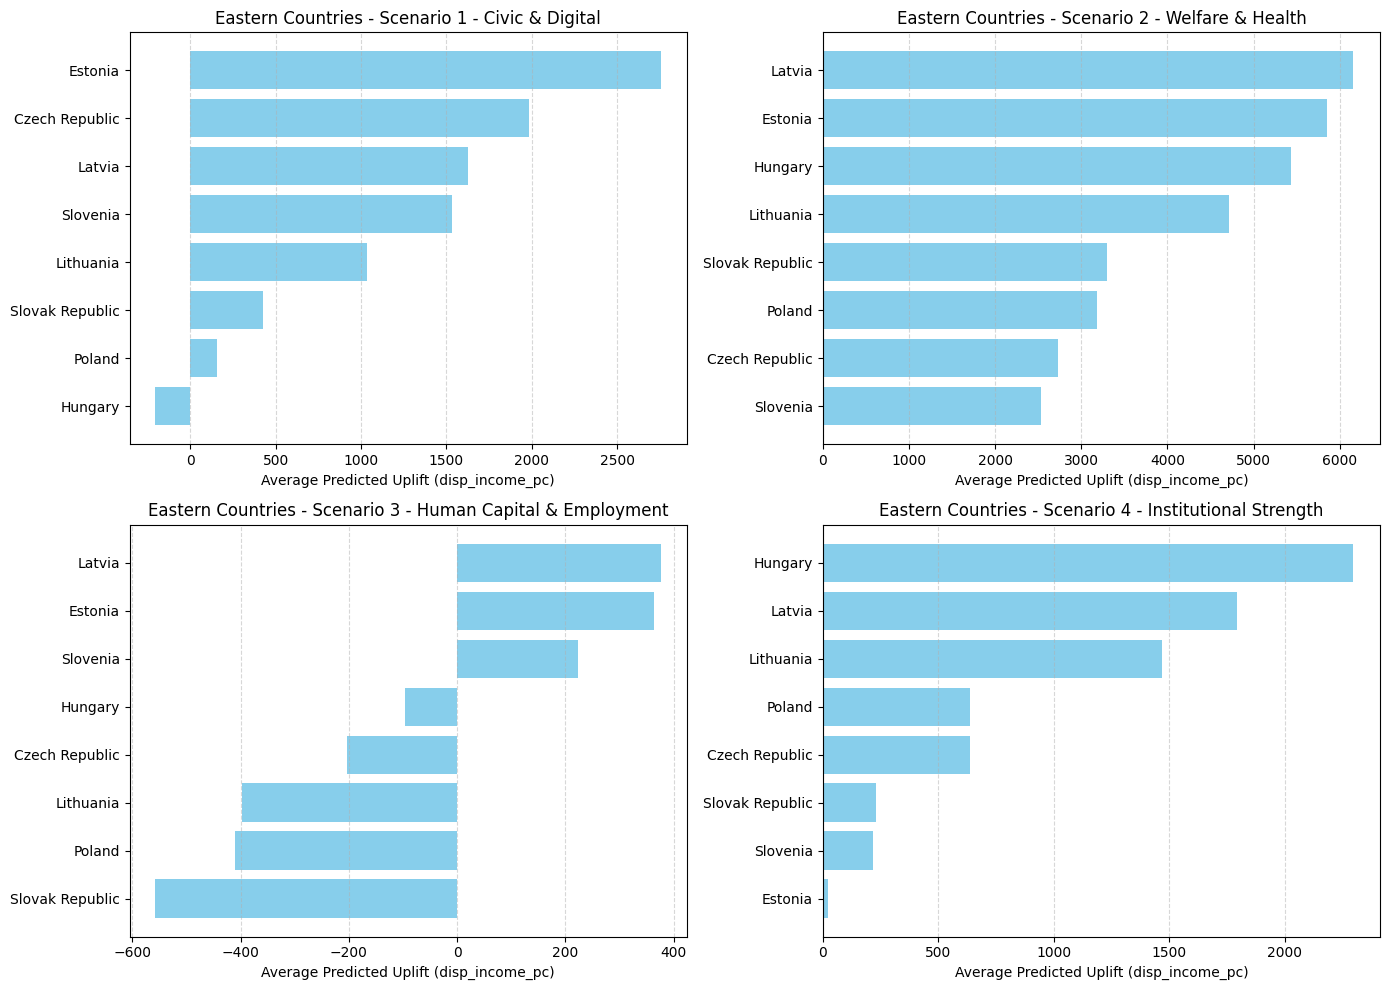

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, features in enumerate(scenario_features_list[:4]):
    scenario_name = scenario_names[i]
    col_uplift = f'uplift_{i+1}'

    X_cf = X_all.copy()
    for f in features:
        X_cf.loc[east_mask, f] = west_means[f]
    df_model[col_uplift] = rf_full.predict(X_cf) - df_model['pred_base']

    by_country = (
        df_model.loc[east_mask]
        .groupby('country')[col_uplift]
        .mean()
        .sort_values(ascending=False)
    )

    ax = axes[i]
    ax.barh(by_country.index[::-1], by_country.values[::-1], color='skyblue')
    ax.set_xlabel('Average Predicted Uplift (disp_income_pc)')
    ax.set_title(f'Eastern Countries - {scenario_name}')
    ax.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

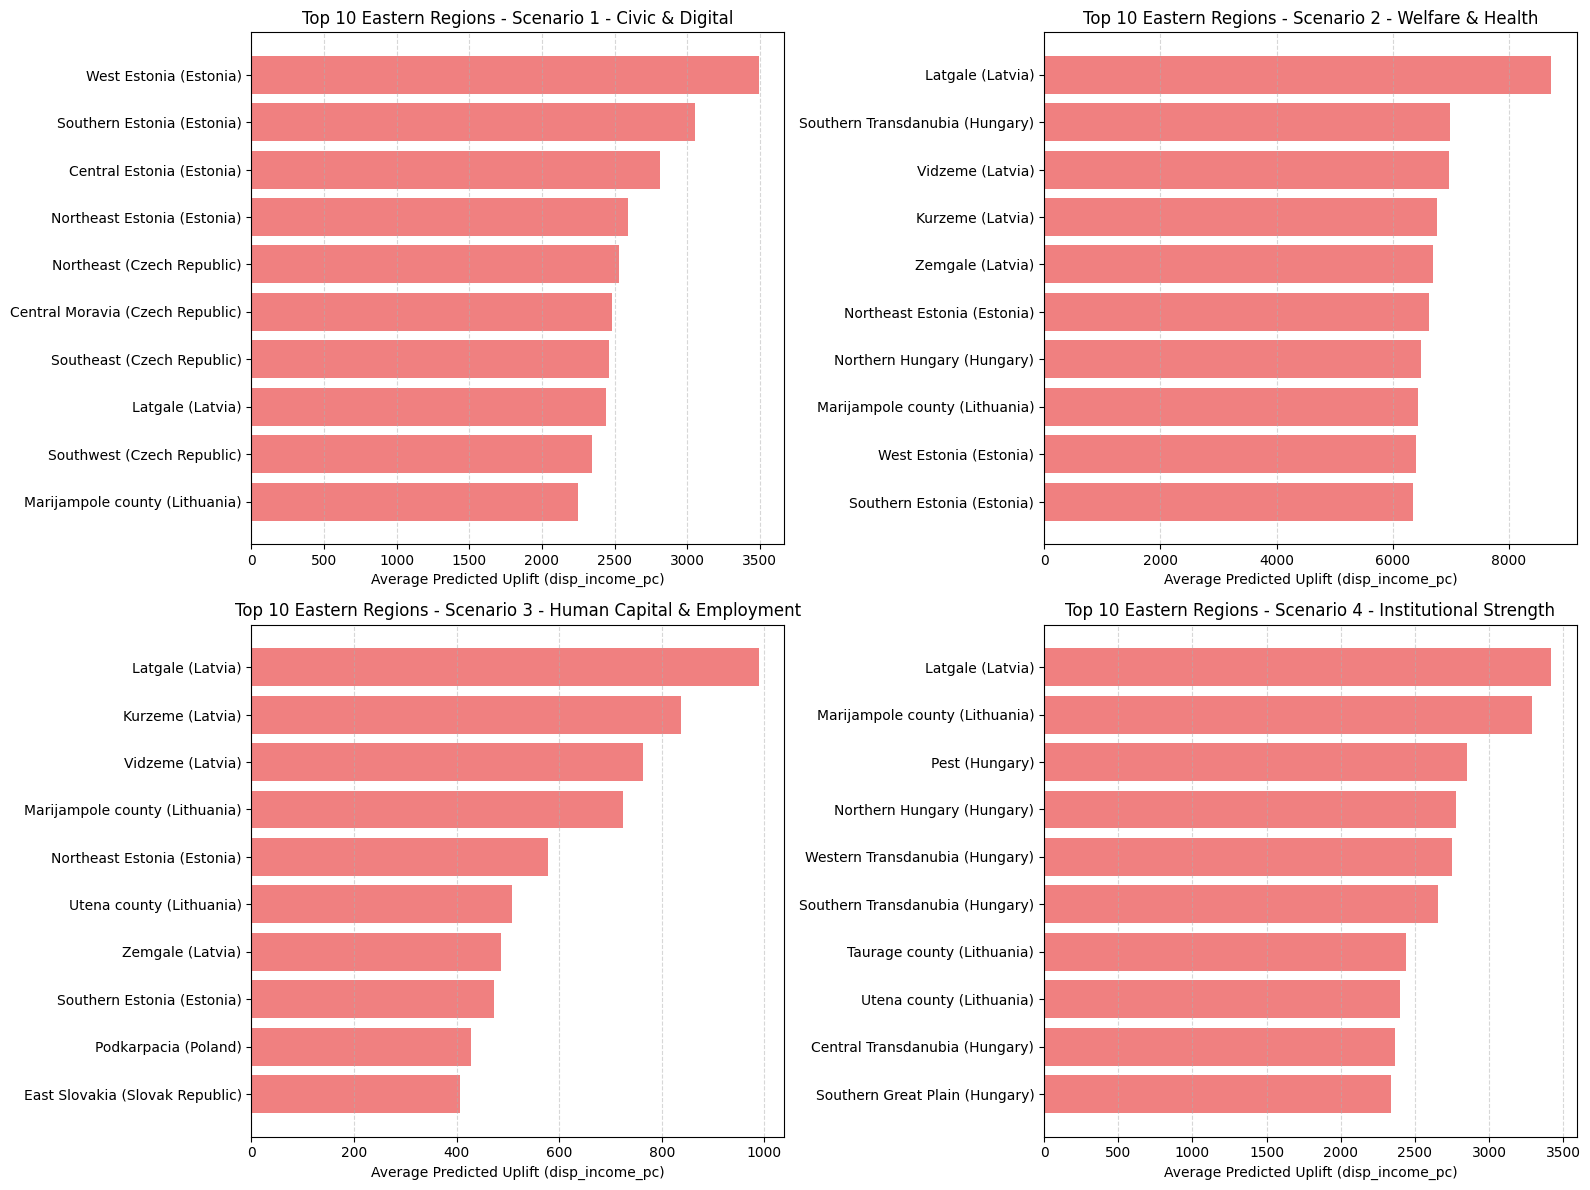

In [41]:
top_n = 10

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, features in enumerate(scenario_features_list[:4]):
    scenario_name = scenario_names[i]
    col_uplift = f'uplift_{i+1}'

    X_cf = X_all.copy()
    for f in features:
        X_cf.loc[east_mask, f] = west_means[f]
    df_model[col_uplift] = rf_full.predict(X_cf) - df_model['pred_base']

    df_east = df_model.loc[east_mask, ['country', 'region', col_uplift]]

    top_regions = df_east.sort_values(col_uplift, ascending=False).head(top_n)

    ax = axes[i]
    ax.barh(
        top_regions['region'][::-1] + ' (' + top_regions['country'][::-1] + ')',
        top_regions[col_uplift][::-1],
        color='lightcoral'
    )
    ax.set_xlabel('Average Predicted Uplift (disp_income_pc)')
    ax.set_title(f'Top {top_n} Eastern Regions - {scenario_name}')
    ax.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [42]:
baseline_mean = df_model.loc[east_mask, 'disp_income_pc'].mean()

uplift_summary_df['Lower_pct'] = uplift_summary_df['2.5%'] / baseline_mean * 100
uplift_summary_df['Lower_pct'] = uplift_summary_df['Lower_pct'].apply(lambda x: f"{x:.2f}%")
uplift_summary_df['Median_pct'] = uplift_summary_df['50%'] / baseline_mean * 100
uplift_summary_df['Median_pct'] = uplift_summary_df['Median_pct'].apply(lambda x: f"{x:.2f}%")
uplift_summary_df['Upper_pct'] = uplift_summary_df['97.5%'] / baseline_mean * 100
uplift_summary_df['Upper_pct'] = uplift_summary_df['Upper_pct'].apply(lambda x: f"{x:.2f}%")


print("Counterfactual Uplift for Eastern Regions (absolute and % vs baseline):")
display(uplift_summary_df.round(2))

Counterfactual Uplift for Eastern Regions (absolute and % vs baseline):


2.5%      50%    97.5% Lower_pct  \
Scenario 1 - Civic & Digital              621.65  1291.48  2217.24     3.84%   
Scenario 2 - Welfare & Health            3461.76  4407.50  5375.99    21.36%   
Scenario 3 - Human Capital & Employment  -401.34   109.89   711.73    -2.48%   
Scenario 4 - Institutional Strength       646.22  1268.17  2264.70     3.99%   

                                        Median_pct Upper_pct  
Scenario 1 - Civic & Digital                 7.97%    13.68%  
Scenario 2 - Welfare & Health               27.20%    33.17%  
Scenario 3 - Human Capital & Employment      0.68%     4.39%  
Scenario 4 - Institutional Strength          7.83%    13.98%